### Supervised Learning - Support Vector Machines
*Nikola Savic at gmail dot com*

## Imports

In [47]:
import time

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [7, 7]

from sklearn.datasets import fetch_openml

from sklearn.preprocessing import StandardScaler 

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve
from sklearn.model_selection import validation_curve
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import average_precision_score
from sklearn.metrics import plot_precision_recall_curve

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import classification_report

from sklearn.svm import SVC

## Fetch, Split and Standardize Data

In [7]:
random_state = 2020

X_cred, y_cred = fetch_openml("credit-g", return_X_y=True)
X_mnist, y_mnist = fetch_openml('mnist_784', version=1, return_X_y=True)

X_cred = pd.DataFrame(X_cred)
y_cred = pd.DataFrame(y_cred)

X_mnist = pd.DataFrame(X_mnist)
y_mnist = pd.DataFrame(y_mnist)

# mapped_back_to_string_label = mapping.take(results)
y_cred[0], cred_mapping = pd.factorize(y_cred[0])
y_mnist[0], mnist_mapping = pd.factorize(y_mnist[0], sort=True)

# Create holdout test set
X_cred_train, X_cred_test, y_cred_train, y_cred_test = train_test_split(X_cred, y_cred, test_size=0.2,
                                                                        random_state=random_state,
                                                                        stratify=y_cred)

X_mnist_train, X_mnist_test, y_mnist_train, y_mnist_test = train_test_split(X_mnist, y_mnist, test_size=0.2,
                                                                            random_state=random_state,
                                                                            stratify=y_mnist)

def get_data(data):
    return data["X"], data["y"], data["name"]

# Standardize
scaler_cred = StandardScaler()
scaler_cred.fit(X_cred_train)
X_cred_train = pd.DataFrame(scaler_cred.transform(X_cred_train), index=y_cred_train.index)
X_cred_test = pd.DataFrame(scaler_cred.transform(X_cred_test), index=y_cred_test.index)

X_mnist_train = pd.DataFrame(X_mnist_train / 255.0, index=y_mnist_train.index)
X_mnist_test = pd.DataFrame(X_mnist_test / 255.0, index=y_mnist_test.index)

# Create data sets
cred = {"X": X_cred_train, "y": y_cred_train, "name": "Credit Train"}
cred_test = {"X": X_cred_test, "y": y_cred_test, "name": "Credit Test"}

mnist = {"X": X_mnist_train, "y": y_mnist_train, "name": "MNIST Train"}

mnist_test = {"X": X_mnist_test, "y": y_mnist_test, "name": "MNIST Test"}

## Shared Functions

In [8]:
def print_cross_val(clf, data_set, cv=5, v=1, n_jobs=-1):
    print(clf)
    X, y, name = get_data(data_set)
    scores = cross_val_score(clf, X, y, cv=cv, scoring='accuracy', verbose=v, n_jobs=n_jobs, pre_dispatch="2*n_jobs")
    time.sleep(1)
    print("{} : {}".format(clf.__class__.__name__, name))
    print("Scores: ", scores, "Avg: ", np.mean(scores))

In [102]:
def build_confusion_matrix(clf, data_set, normalize="true"):
    print(clf)
    X, y, name = get_data(data_set)
    title = "{} : {}".format(clf.__class__.__name__, name)
    disp = plot_confusion_matrix(clf, X, y, normalize=normalize, cmap=plt.cm.Blues)
    disp.ax_.set_title(title)

In [10]:
def build_learning_curve(clf, data_set, scoring="accuracy", axes=None, ylim=None, cv=5, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    print(clf)
    X, y, name = get_data(data_set)
    title = "{} : {}".format(clf.__class__.__name__, name)
    
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(30, 10))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel(scoring)

    train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
        clf, X, y, cv=cv, n_jobs=n_jobs, scoring=scoring, train_sizes=train_sizes, return_times=True, random_state=random_state
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel(scoring)
    axes[2].set_title("Performance of the model")
    plt.show()

In [11]:
def build_validation_curve(clf, data_set, param_name, param_range, scoring="accuracy", cv=5):
    print(clf)
    X, y, name = get_data(data_set)
    
    train_scores, test_scores = validation_curve(
        clf, X, y, param_name=param_name, param_range=param_range, scoring=scoring, cv=cv, n_jobs=-1
    )
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    train_scores_max = np.max(train_scores_mean)
    train_scores_max_idx = np.argmax(train_scores_mean)
    train_scores_max_x = param_range[train_scores_max_idx]
    
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    test_scores_max = np.max(test_scores_mean)
    test_scores_max_idx = np.argmax(test_scores_mean)
    test_scores_max_x = param_range[test_scores_max_idx]

    plt.title("Validation Curve with " + clf.__class__.__name__ + " : " + name)
    plt.xlabel(param_name)
    plt.ylabel(scoring)
    plt.ylim(0.0, 1.1)
    lw = 2
    
    plt.plot(param_range, train_scores_mean, label="Training score", color="darkorange", lw=lw,
              marker="x",markeredgewidth=3, ms=8, markevery=[train_scores_max_idx])

    plt.fill_between(param_range, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="darkorange", lw=lw)

    plt.plot(param_range, test_scores_mean, label="Test score", color="navy", lw=lw,
             marker="x", markeredgewidth=3, ms=8, markevery=[test_scores_max_idx])

    plt.fill_between(param_range, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="navy", lw=lw)
    
    # Plot a dotted vertical line at the best score for that scorer marked by x
    plt.axvline(x=train_scores_max_x, linestyle="--", color="darkorange")
    plt.annotate("Train %0.2f" % train_scores_max, (train_scores_max_x, train_scores_max + 0.05))
   
    plt.axvline(x=test_scores_max_x, linestyle="--", color="navy")
    plt.annotate("Test %0.2f" % test_scores_max, (test_scores_max_x, test_scores_max + 0.05))

    plt.legend(loc="best")
    plt.show()

In [13]:
def build_logx_validation_curve(clf, data_set, param_name, param_range, scoring="accuracy", cv=5):
    print(clf)
    X, y, name = get_data(data_set)
    
    train_scores, test_scores = validation_curve(
        clf, X, y, param_name=param_name, param_range=param_range, scoring=scoring, cv=cv, n_jobs=-1
    )
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    train_scores_max = np.max(train_scores_mean)
    train_scores_max_idx = np.argmax(train_scores_mean)
    train_scores_max_x = param_range[train_scores_max_idx]
    
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    test_scores_max = np.max(test_scores_mean)
    test_scores_max_idx = np.argmax(test_scores_mean)
    test_scores_max_x = param_range[test_scores_max_idx]

    plt.title("Validation Curve with " + clf.__class__.__name__ + " : " + name)
    plt.xlabel(param_name)
    plt.ylabel(scoring)
    plt.ylim(0.0, 1.1)
    lw = 2
    
    plt.semilogx(param_range, train_scores_mean, label="Training score", color="darkorange", lw=lw,
                marker="x",markeredgewidth=3, ms=8, markevery=[train_scores_max_idx])
    plt.fill_between(param_range, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="darkorange", lw=lw)

    plt.semilogx(param_range, test_scores_mean, label="Cross-validation score", color="navy", lw=lw,
                 marker="x",markeredgewidth=3, ms=8, markevery=[test_scores_max_idx])

    plt.fill_between(param_range, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="navy", lw=lw)
    
    # Plot a dotted vertical line at the best score for that scorer marked by x
    plt.axvline(x=train_scores_max_x, linestyle="--", color="darkorange")
    plt.annotate("Train %0.2f" % train_scores_max, (train_scores_max_x, train_scores_max + 0.05))
   
    plt.axvline(x=test_scores_max_x, linestyle="--", color="navy")
    plt.annotate("Test %0.2f" % test_scores_max, (test_scores_max_x, test_scores_max + 0.05))

    plt.legend(loc="best")
    plt.show()

In [14]:
def print_gridsearch(data_set, parameters = {"random_state": random_state}, tuned_parameters={}, scores=["accuracy"]):
    X, y, name = get_data(data_set)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=random_state)

    best = []
    for score in scores:
        print("# Tuning hyper-parameters for %s" % score)
        print()

        clf = GridSearchCV(SVC(**parameters), tuned_parameters, scoring=score, n_jobs=-1)
        clf.fit(X_train, y_train.values.ravel())

        print("Best parameters set found on development set:")
        print()
        print(clf.best_params_)
        best.append((clf.best_score_, clf.best_params_, clf.best_estimator_))
        print()
        print("Grid scores on development set:")
        print()
        means = clf.cv_results_['mean_test_score']
        stds = clf.cv_results_['std_test_score']
        for mean, std, params in zip(means, stds, clf.cv_results_['params']):
            print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
        print()

        print("Detailed classification report:")
        print()
        print("The model is trained on the full development set.")
        print("The scores are computed on the full evaluation set.")
        print()
        y_true, y_pred = y_test, clf.predict(X_test)
        print(classification_report(y_true, y_pred))
        print()

    print("Best parameters")
    for i in range(len(best)):
        print(scores[i])
        print(best[i])

In [25]:
def build_cred_precision_recall_curve(clf, data_set):
    print(clf)
    X, y, name = get_data(data_set)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.5, random_state=random_state)
    
    clf.fit(X_train, y_train)
    y_score = clf.predict(X_test)
    disp = plot_precision_recall_curve(clf, X_test, y_test)
    disp.ax_.set_title('{0} Precision-Recall curve'.format(name))

## Classifer: Support Vector Machine

In [16]:
# Credit SVM
C = 10
gamma = 0.01
kernel = "linear"
cache_size=60000
csvm = SVC(C=C,
           gamma=gamma,
           kernel=kernel,
           cache_size=cache_size,
           random_state=random_state)
csvm

SVC(C=10, break_ties=False, cache_size=60000, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.01, kernel='linear',
    max_iter=-1, probability=False, random_state=2020, shrinking=True,
    tol=0.001, verbose=False)

In [17]:
# MNIST SVM
C = 50
gamma = 0.001
kernel = "rbf"
cache_size = 60000
msvm = SVC(C=C,
           gamma=gamma,
           kernel=kernel,
           cache_size=cache_size,
           random_state=random_state)
msvm

SVC(C=50, break_ties=False, cache_size=60000, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
    max_iter=-1, probability=False, random_state=2020, shrinking=True,
    tol=0.001, verbose=False)

## cross_val scores - accuracy

In [18]:
C = 10
gamma = 0.01
kernel = "linear"
cache_size=60000
csvm = SVC(C=C,
           gamma=gamma,
           kernel=kernel,
           cache_size=cache_size,
           random_state=random_state)
print_cross_val(csvm, cred)

SVC(C=10, break_ties=False, cache_size=60000, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.01, kernel='linear',
    max_iter=-1, probability=False, random_state=2020, shrinking=True,
    tol=0.001, verbose=False)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.5s finished


SVC : Credit Train
Scores:  [0.75625 0.76875 0.75625 0.775   0.725  ] Avg:  0.75625


In [19]:
C = 50
gamma = 0.001
kernel = "rbf"
cache_size = 60000
msvm = SVC(C=C,
           gamma=gamma,
           kernel=kernel,
           cache_size=cache_size,
           random_state=random_state)
print_cross_val(msvm, mnist)

SVC(C=50, break_ties=False, cache_size=60000, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
    max_iter=-1, probability=False, random_state=2020, shrinking=True,
    tol=0.001, verbose=False)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  5.8min finished


SVC : MNIST Train
Scores:  [0.96223214 0.96696429 0.96303571 0.96741071 0.96348214] Avg:  0.9646250000000001


## Learning Curves

SVC(C=5, break_ties=False, cache_size=60000, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.01, kernel='linear',
    max_iter=-1, probability=False, random_state=2020, shrinking=True,
    tol=0.001, verbose=False)


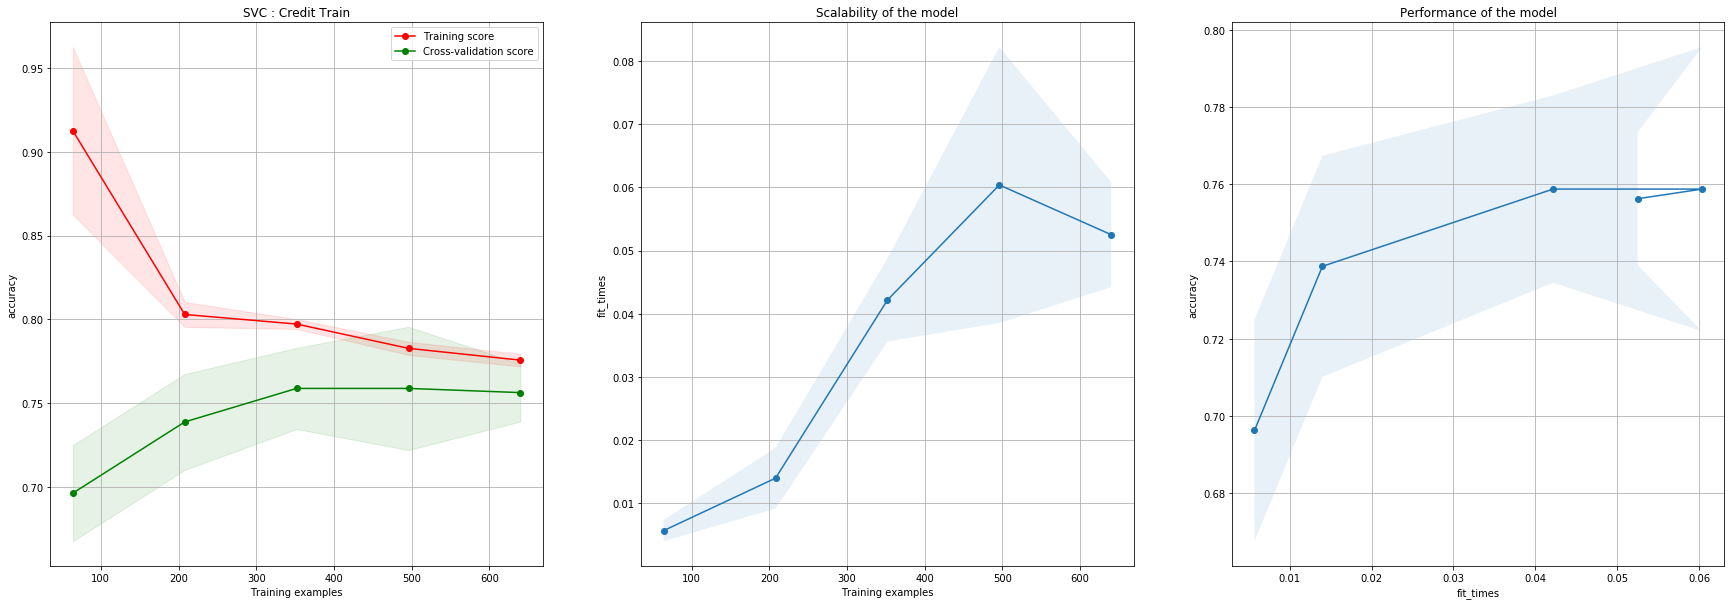

In [34]:
C = 5
gamma = 0.01
kernel = "linear"
cache_size=60000
csvm = SVC(C=C,
           gamma=gamma,
           kernel=kernel,
           cache_size=cache_size,
           random_state=random_state)
build_learning_curve(csvm, cred)

SVC(C=5, break_ties=False, cache_size=60000, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.01, kernel='linear',
    max_iter=-1, probability=False, random_state=2020, shrinking=True,
    tol=0.001, verbose=False)


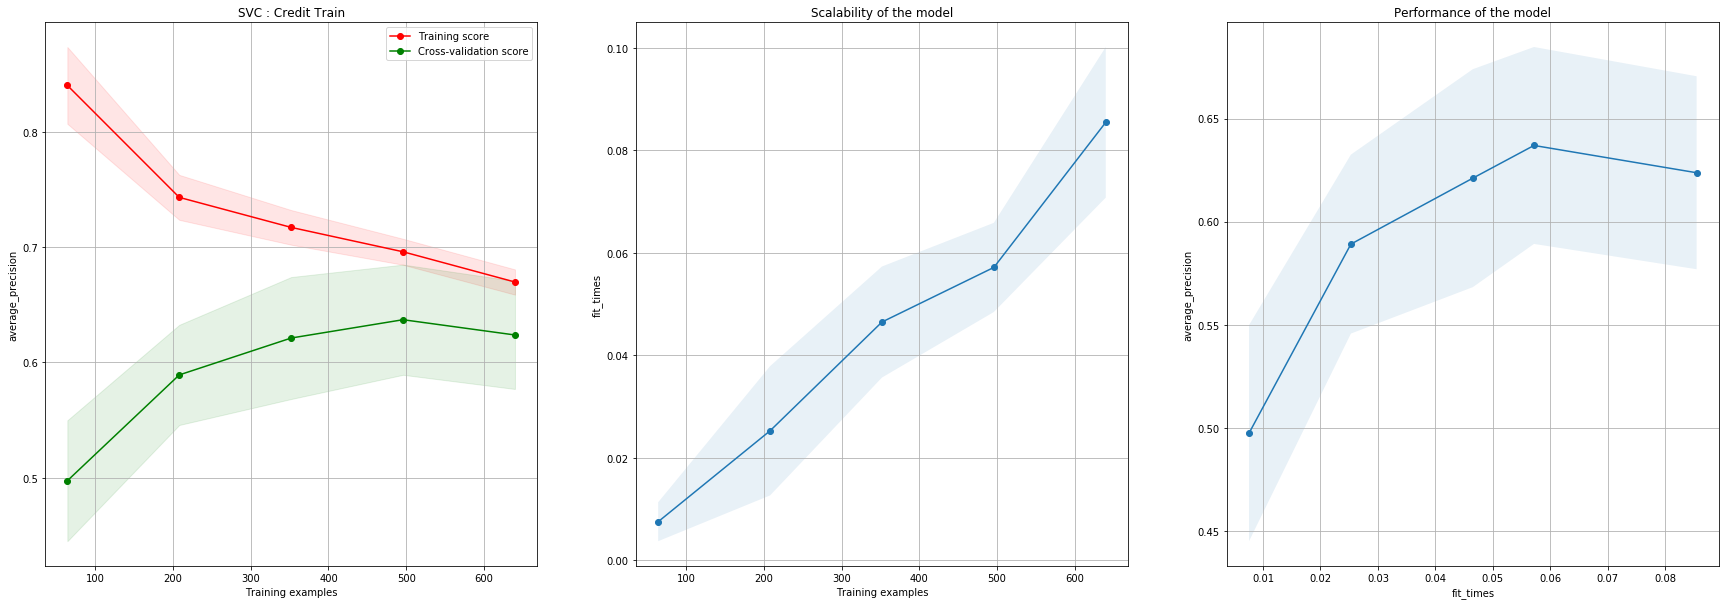

In [70]:
C = 5
gamma = 0.01
kernel = "linear"
cache_size=60000
csvm = SVC(C=C,
           gamma=gamma,
           kernel=kernel,
           cache_size=cache_size,
           random_state=random_state)
build_learning_curve(csvm, cred, scoring="average_precision")

SVC(C=5, break_ties=False, cache_size=60000, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
    max_iter=-1, probability=False, random_state=2020, shrinking=True,
    tol=0.001, verbose=False)


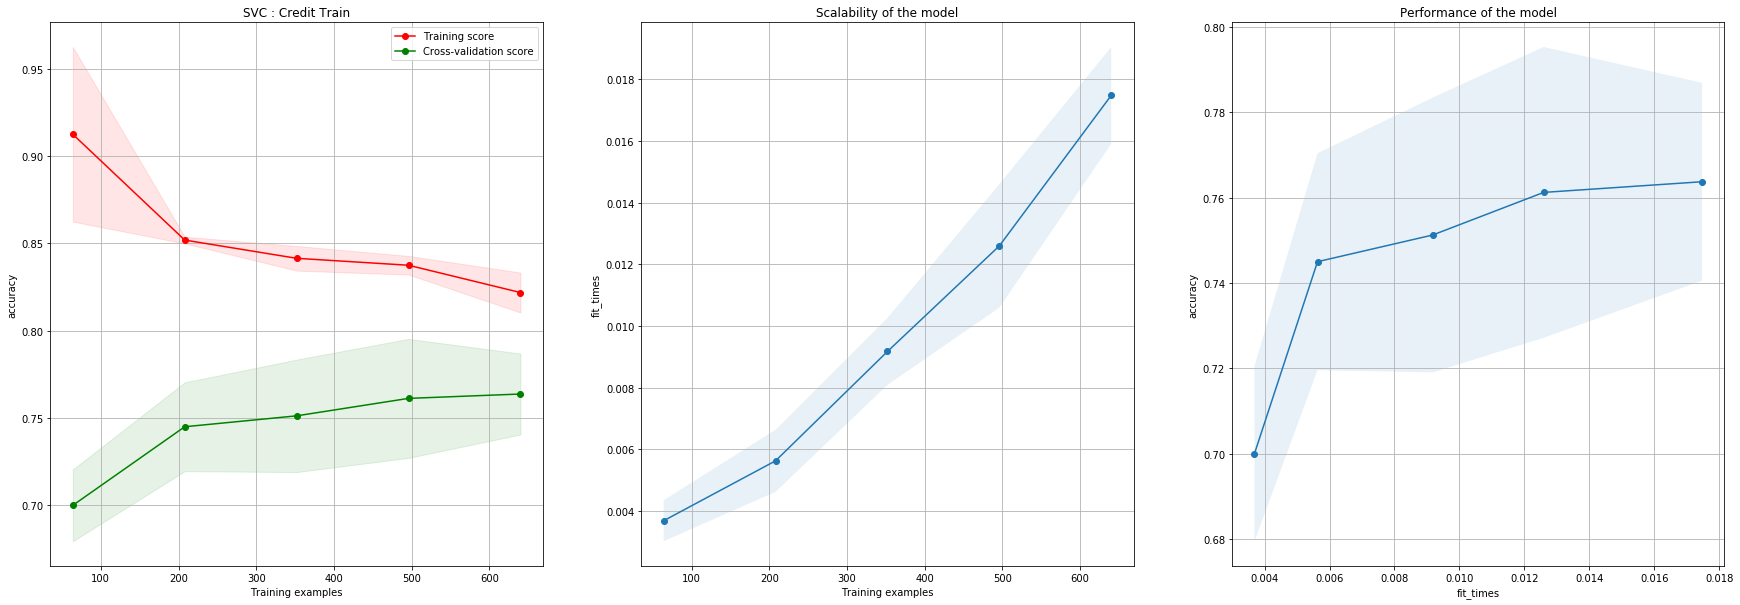

In [81]:
C = 5
gamma = 0.01
kernel = "rbf"
cache_size=60000
csvm = SVC(C=C,
           gamma=gamma,
           kernel=kernel,
           cache_size=cache_size,
           random_state=random_state)
build_learning_curve(csvm, cred)

SVC(C=5, break_ties=False, cache_size=60000, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
    max_iter=-1, probability=False, random_state=2020, shrinking=True,
    tol=0.001, verbose=False)


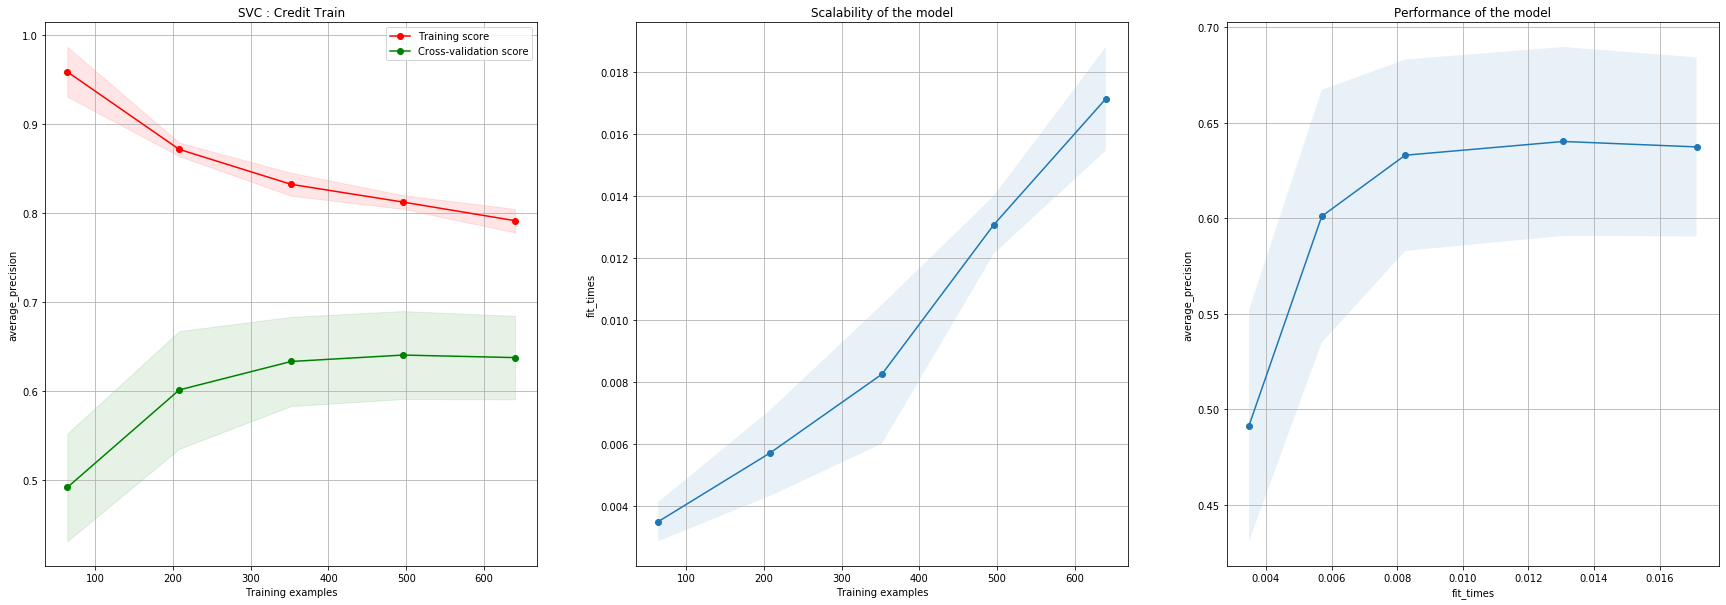

In [80]:
C = 5
gamma = 0.01
kernel = "rbf"
cache_size=60000
csvm = SVC(C=C,
           gamma=gamma,
           kernel=kernel,
           cache_size=cache_size,
           random_state=random_state)
build_learning_curve(csvm, cred, scoring="average_precision")

SVC(C=10, break_ties=False, cache_size=60000, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
    max_iter=-1, probability=False, random_state=2020, shrinking=True,
    tol=0.001, verbose=False)


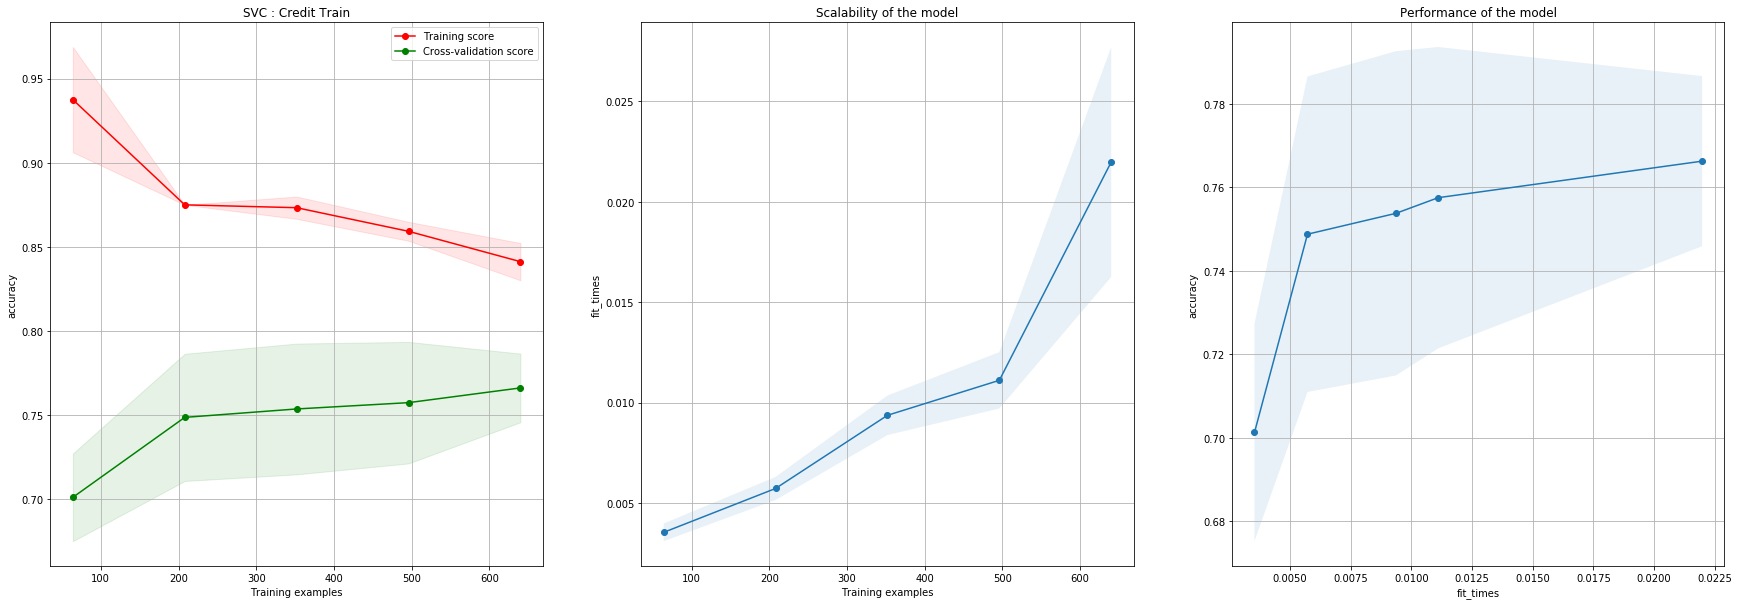

In [123]:
C = 10
gamma = 0.01
kernel = "linear"
cache_size=60000
csvm = SVC(C=C,
           gamma=gamma,
           kernel=kernel,
           cache_size=cache_size,
           random_state=random_state)
build_learning_curve(csvm, cred)

SVC(C=20, break_ties=False, cache_size=60000, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.01, kernel='linear',
    max_iter=-1, probability=False, random_state=2020, shrinking=True,
    tol=0.001, verbose=False)


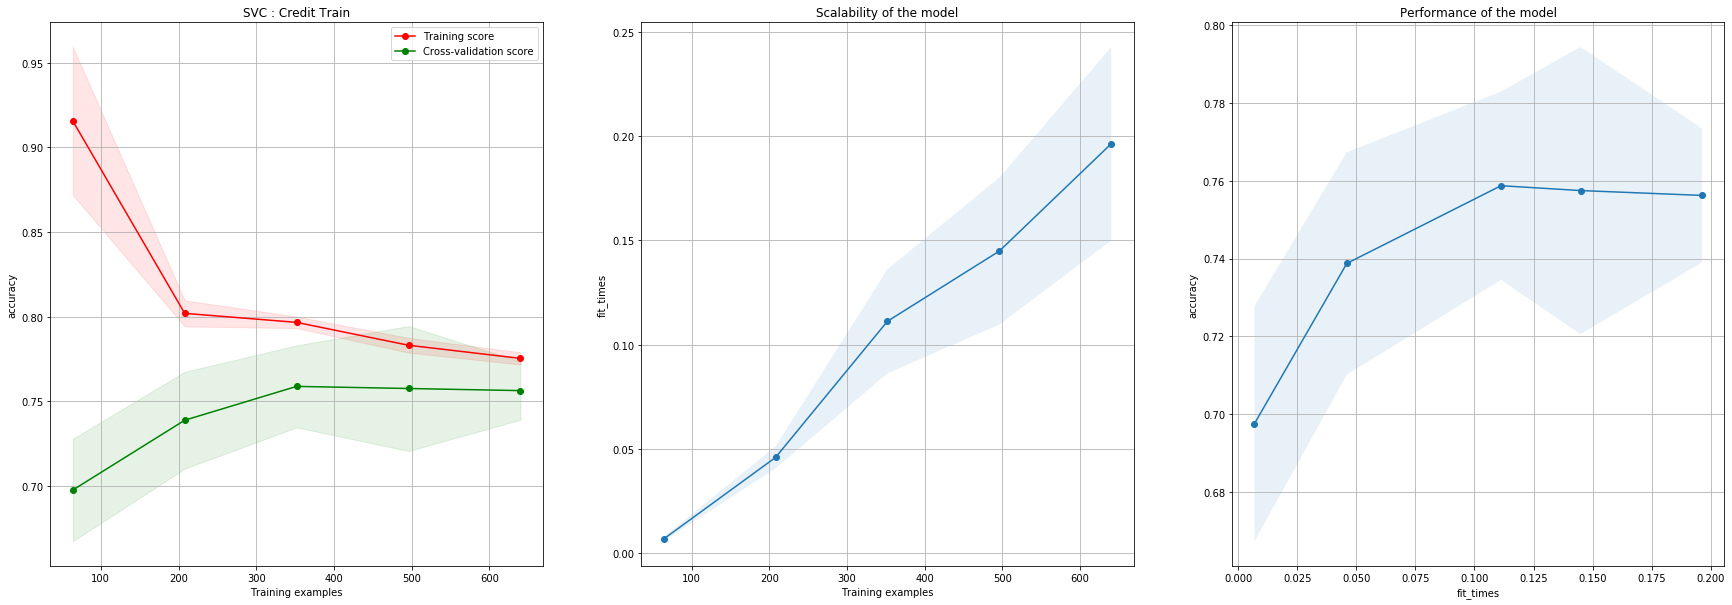

In [35]:
C = 20
gamma = 0.01
kernel = "linear"
cache_size=60000
csvm = SVC(C=C,
           gamma=gamma,
           kernel=kernel,
           cache_size=cache_size,
           random_state=random_state)
build_learning_curve(csvm, cred)

SVC(C=10, break_ties=False, cache_size=60000, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.01, kernel='linear',
    max_iter=-1, probability=False, random_state=2020, shrinking=True,
    tol=0.001, verbose=False)


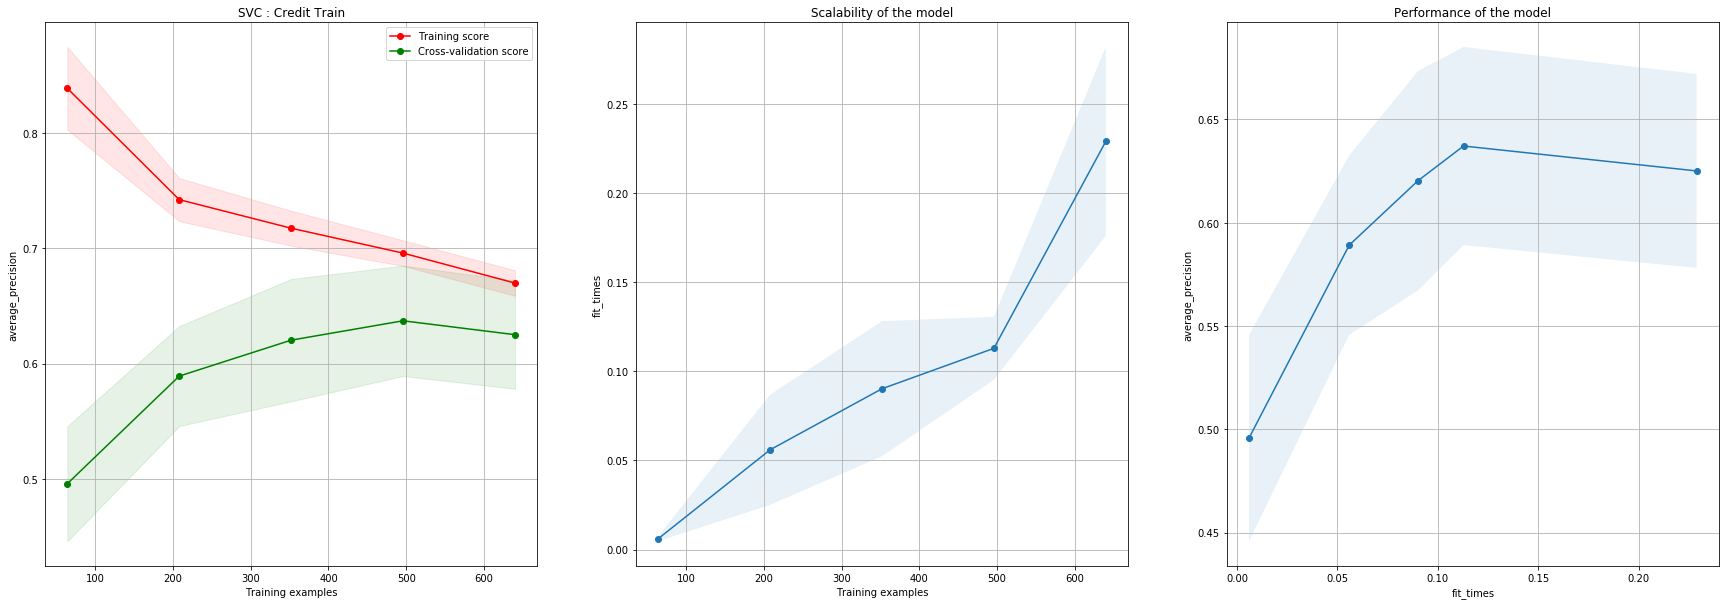

In [20]:
C = 10
gamma = 0.01
kernel = "linear"
cache_size=60000
csvm = SVC(C=C,
           gamma=gamma,
           kernel=kernel,
           cache_size=cache_size,
           random_state=random_state)
build_learning_curve(csvm, cred, scoring="average_precision")

SVC(C=5, break_ties=False, cache_size=60000, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
    max_iter=-1, probability=False, random_state=2020, shrinking=True,
    tol=0.001, verbose=False)


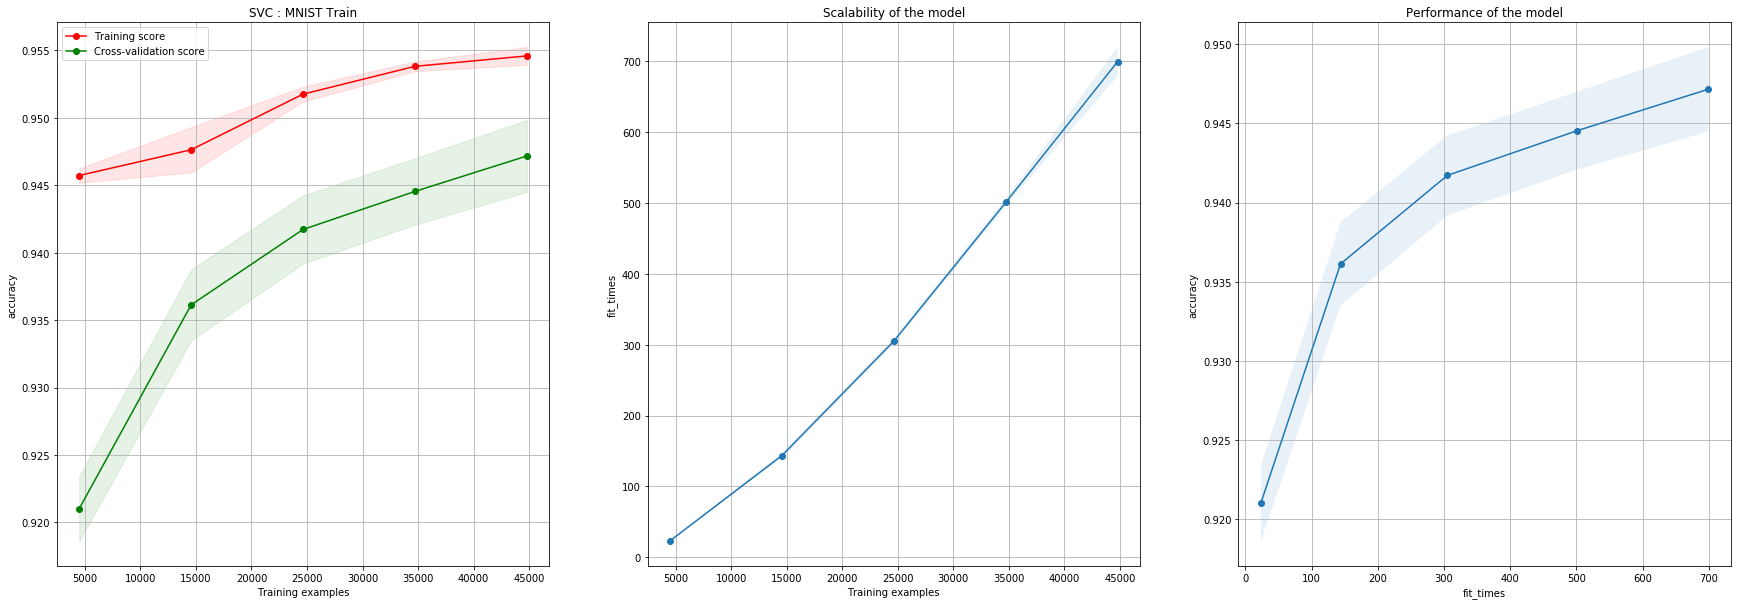

In [31]:
C = 5
gamma = 0.001
kernel = "rbf"
cache_size = 60000
msvm = SVC(C=C,
           gamma=gamma,
           kernel=kernel,
           cache_size=cache_size,
           random_state=random_state)
build_learning_curve(msvm, mnist)

SVC(C=10, break_ties=False, cache_size=60000, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
    max_iter=-1, probability=False, random_state=2020, shrinking=True,
    tol=0.001, verbose=False)


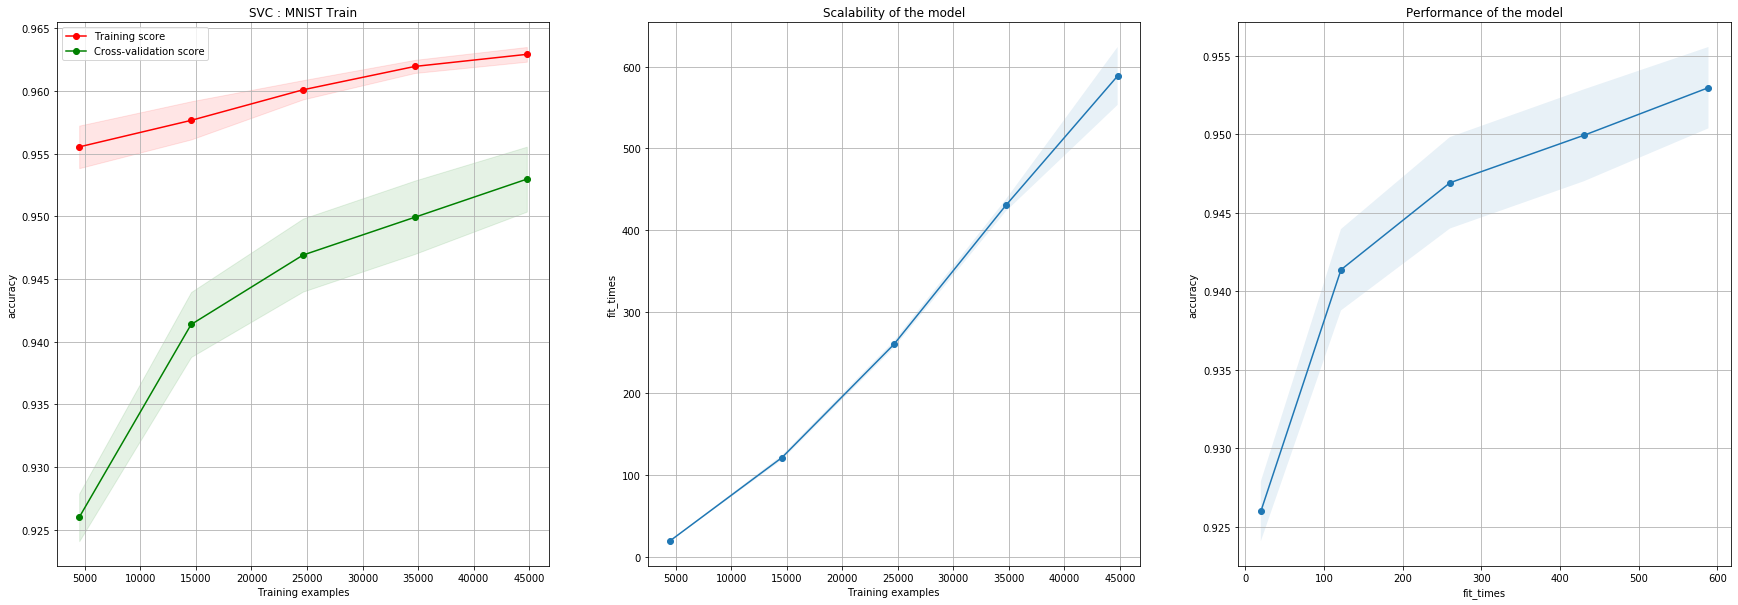

In [30]:
C = 10
gamma = 0.001
kernel = "rbf"
cache_size = 60000
msvm = SVC(C=C,
           gamma=gamma,
           kernel=kernel,
           cache_size=cache_size,
           random_state=random_state)
build_learning_curve(msvm, mnist)

SVC(C=15, break_ties=False, cache_size=60000, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
    max_iter=-1, probability=False, random_state=2020, shrinking=True,
    tol=0.001, verbose=False)


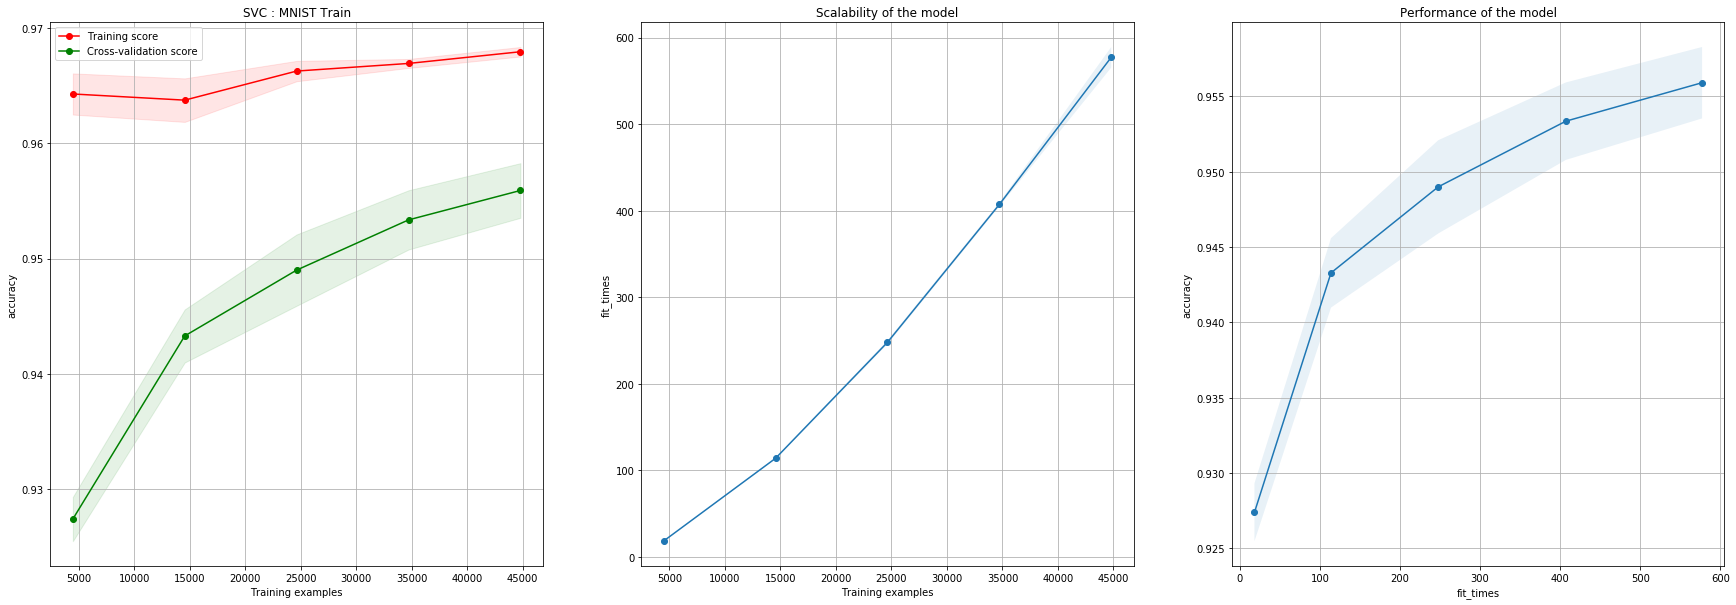

In [32]:
C = 15
gamma = 0.001
kernel = "rbf"
cache_size = 60000
msvm = SVC(C=C,
           gamma=gamma,
           kernel=kernel,
           cache_size=cache_size,
           random_state=random_state)
build_learning_curve(msvm, mnist)

SVC(C=17, break_ties=False, cache_size=60000, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
    max_iter=-1, probability=False, random_state=2020, shrinking=True,
    tol=0.001, verbose=False)


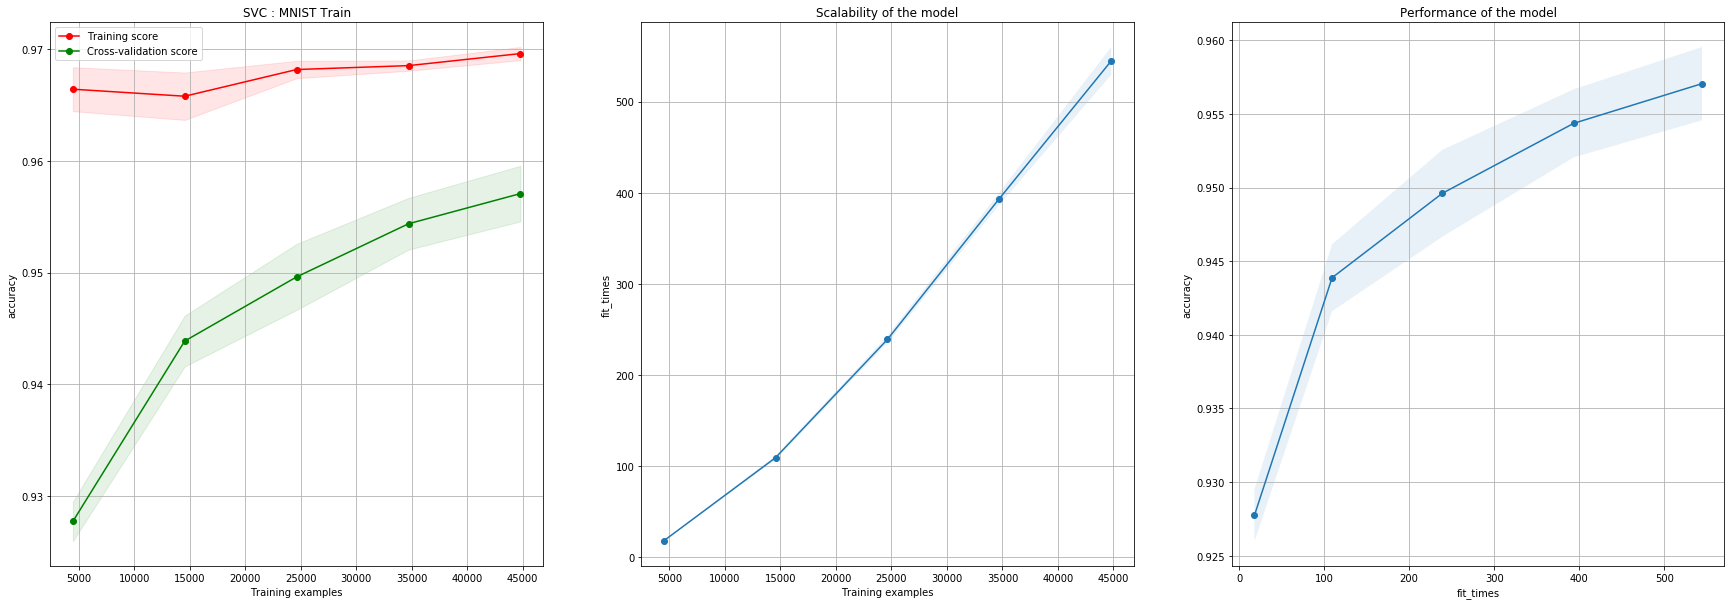

In [40]:
C = 17
gamma = 0.001
kernel = "rbf"
cache_size = 60000
msvm = SVC(C=C,
           gamma=gamma,
           kernel=kernel,
           cache_size=cache_size,
           random_state=random_state)
build_learning_curve(msvm, mnist)

SVC(C=18, break_ties=False, cache_size=60000, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
    max_iter=-1, probability=False, random_state=2020, shrinking=True,
    tol=0.001, verbose=False)


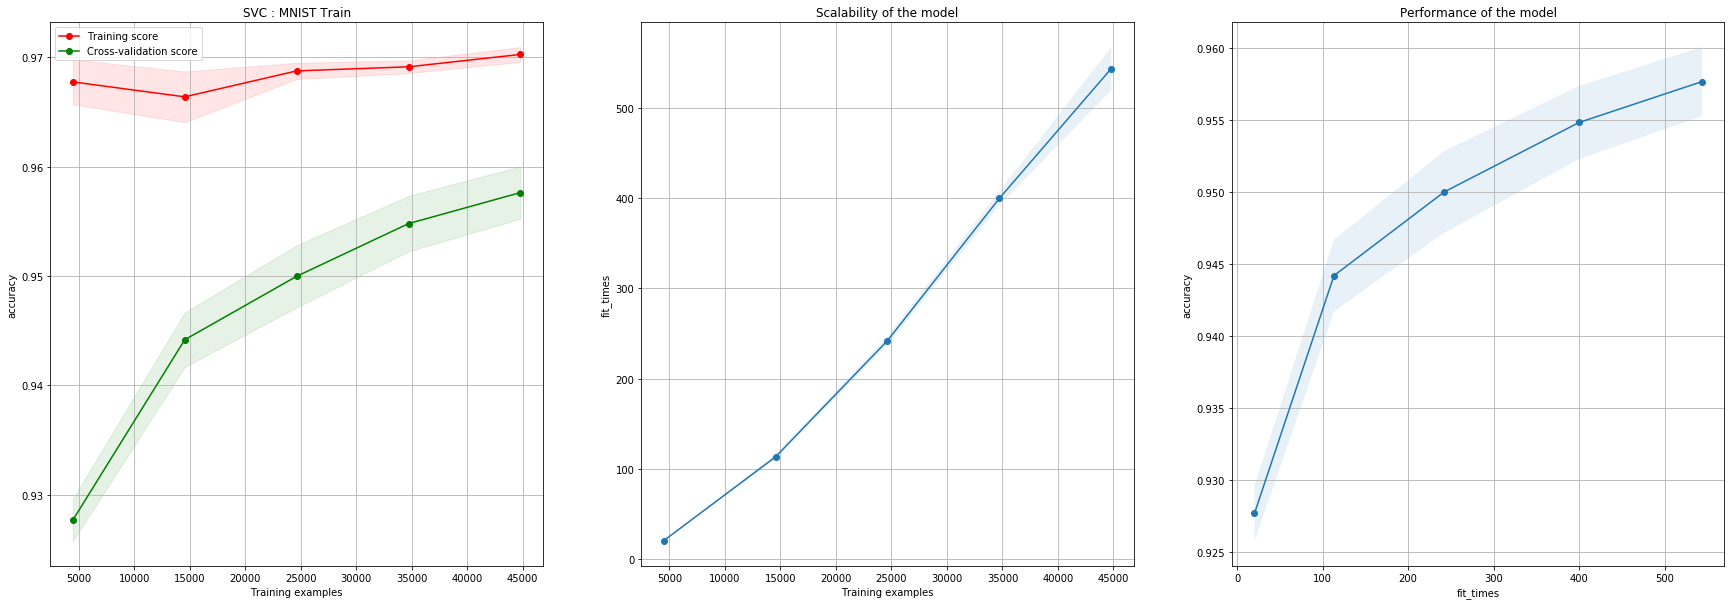

In [41]:
C = 18
gamma = 0.001
kernel = "rbf"
cache_size = 60000
msvm = SVC(C=C,
           gamma=gamma,
           kernel=kernel,
           cache_size=cache_size,
           random_state=random_state)
build_learning_curve(msvm, mnist)

SVC(C=19, break_ties=False, cache_size=60000, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
    max_iter=-1, probability=False, random_state=2020, shrinking=True,
    tol=0.001, verbose=False)


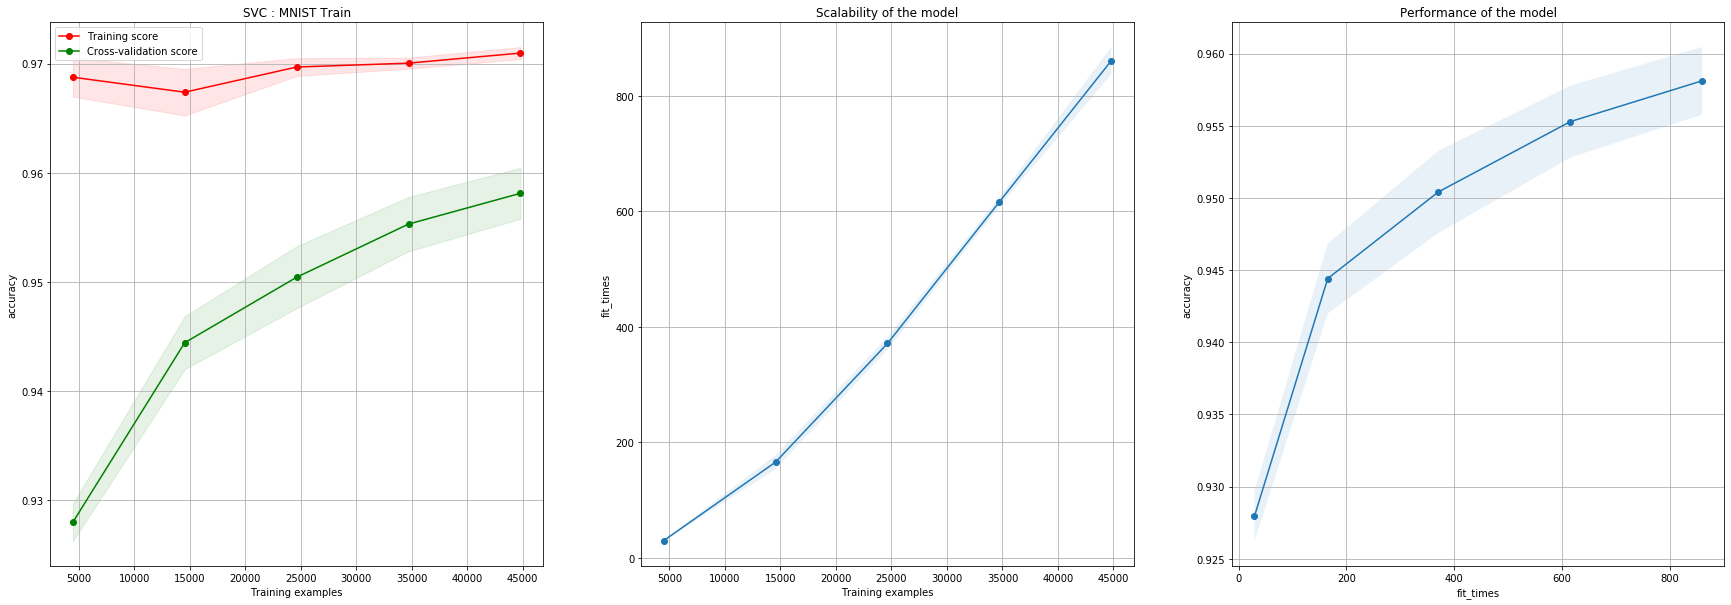

In [50]:
C = 19
gamma = 0.001
kernel = "rbf"
cache_size = 60000
msvm = SVC(C=C,
           gamma=gamma,
           kernel=kernel,
           cache_size=cache_size,
           random_state=random_state)
build_learning_curve(msvm, mnist)

SVC(C=20, break_ties=False, cache_size=60000, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
    max_iter=-1, probability=False, random_state=2020, shrinking=True,
    tol=0.001, verbose=False)


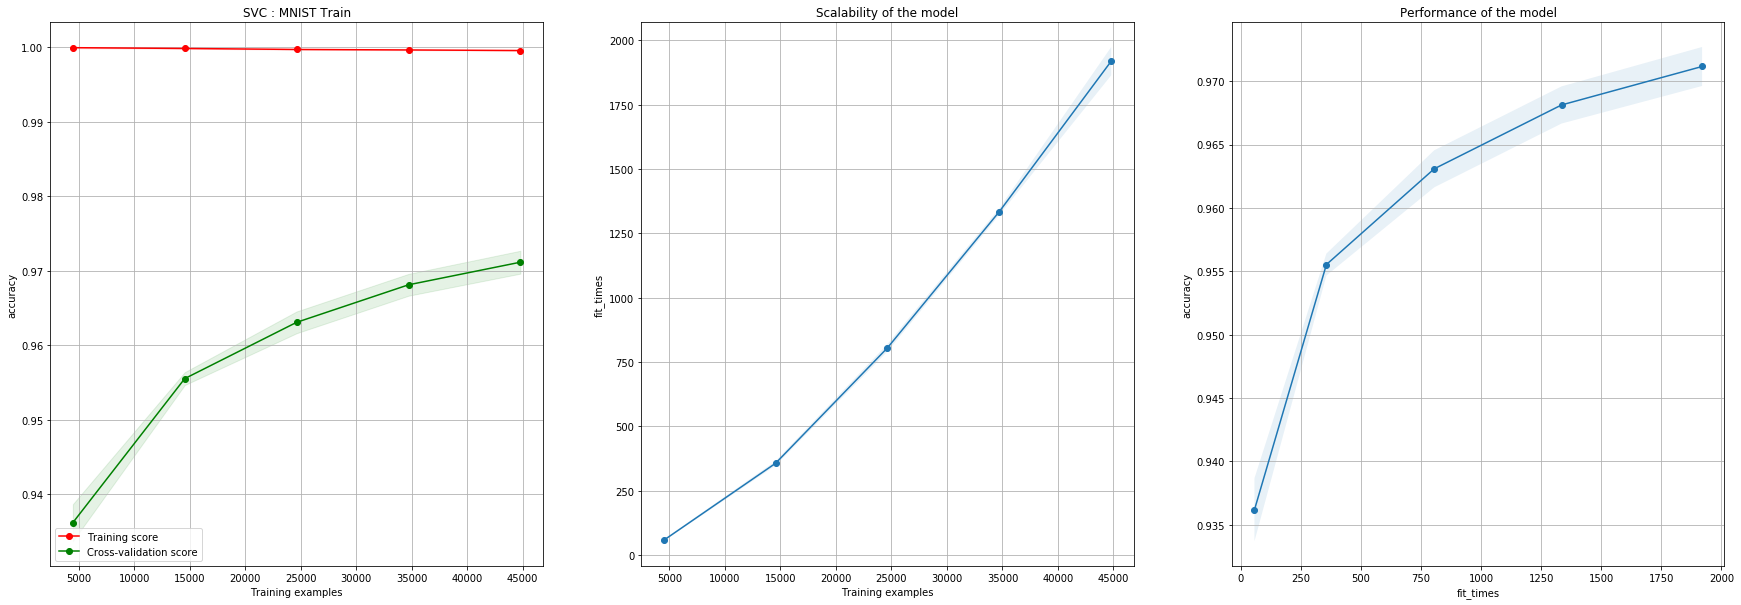

In [133]:
C = 20
gamma = 0.001
kernel = "rbf"
cache_size = 60000
msvm = SVC(C=C,
           gamma=gamma,
           kernel=kernel,
           cache_size=cache_size,
           random_state=random_state)
build_learning_curve(msvm, mnist)

SVC(C=50, break_ties=False, cache_size=60000, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
    max_iter=-1, probability=False, random_state=2020, shrinking=True,
    tol=0.001, verbose=False)


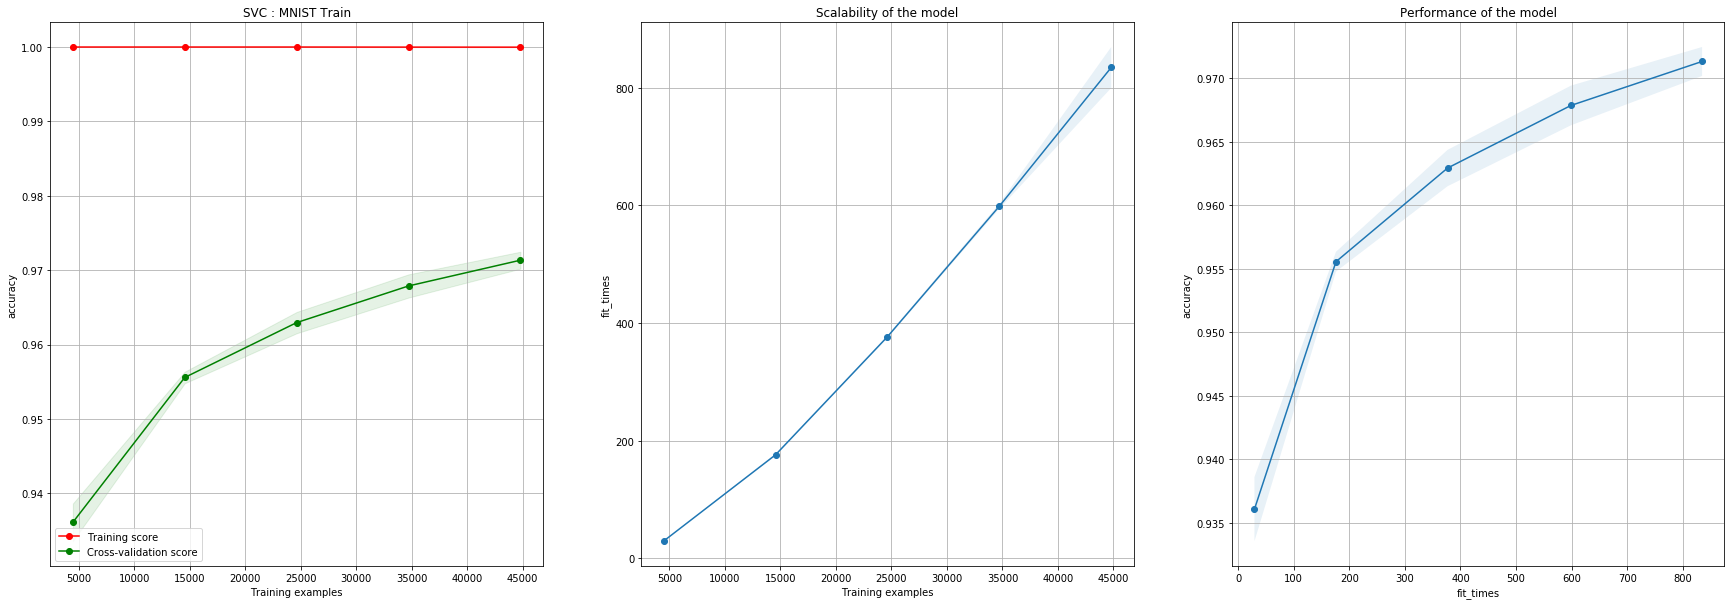

In [153]:
C = 50
gamma = 0.001
kernel = "rbf"
cache_size = 60000
msvm = SVC(C=C,
           gamma=gamma,
           kernel=kernel,
           cache_size=cache_size,
           random_state=random_state)
build_learning_curve(msvm, mnist)

SVC(C=100, break_ties=False, cache_size=60000, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
    max_iter=-1, probability=False, random_state=2020, shrinking=True,
    tol=0.001, verbose=False)


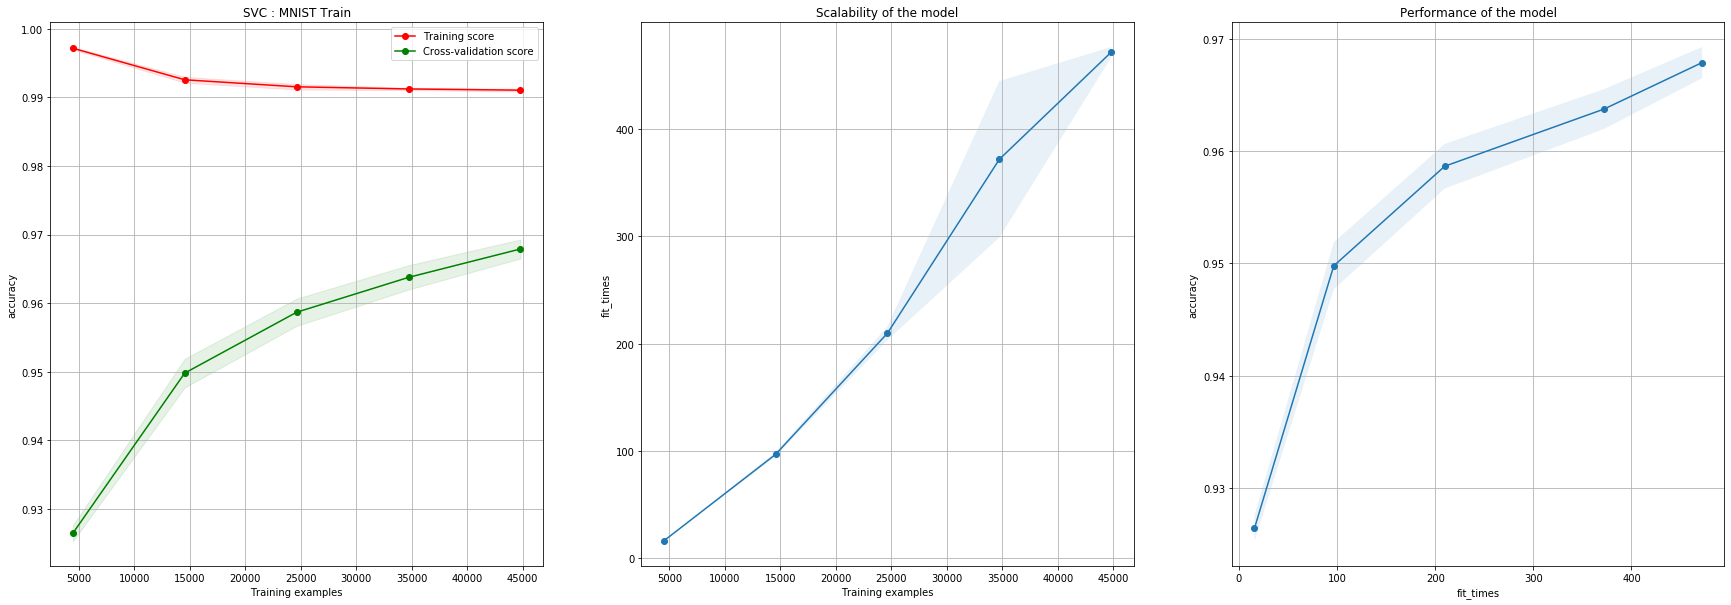

In [36]:
C = 100
gamma = 0.001
kernel = "rbf"
cache_size = 60000
msvm = SVC(C=C,
           gamma=gamma,
           kernel=kernel,
           cache_size=cache_size,
           random_state=random_state)
build_learning_curve(msvm, mnist)

SVC(C=500, break_ties=False, cache_size=60000, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
    max_iter=-1, probability=False, random_state=2020, shrinking=True,
    tol=0.001, verbose=False)


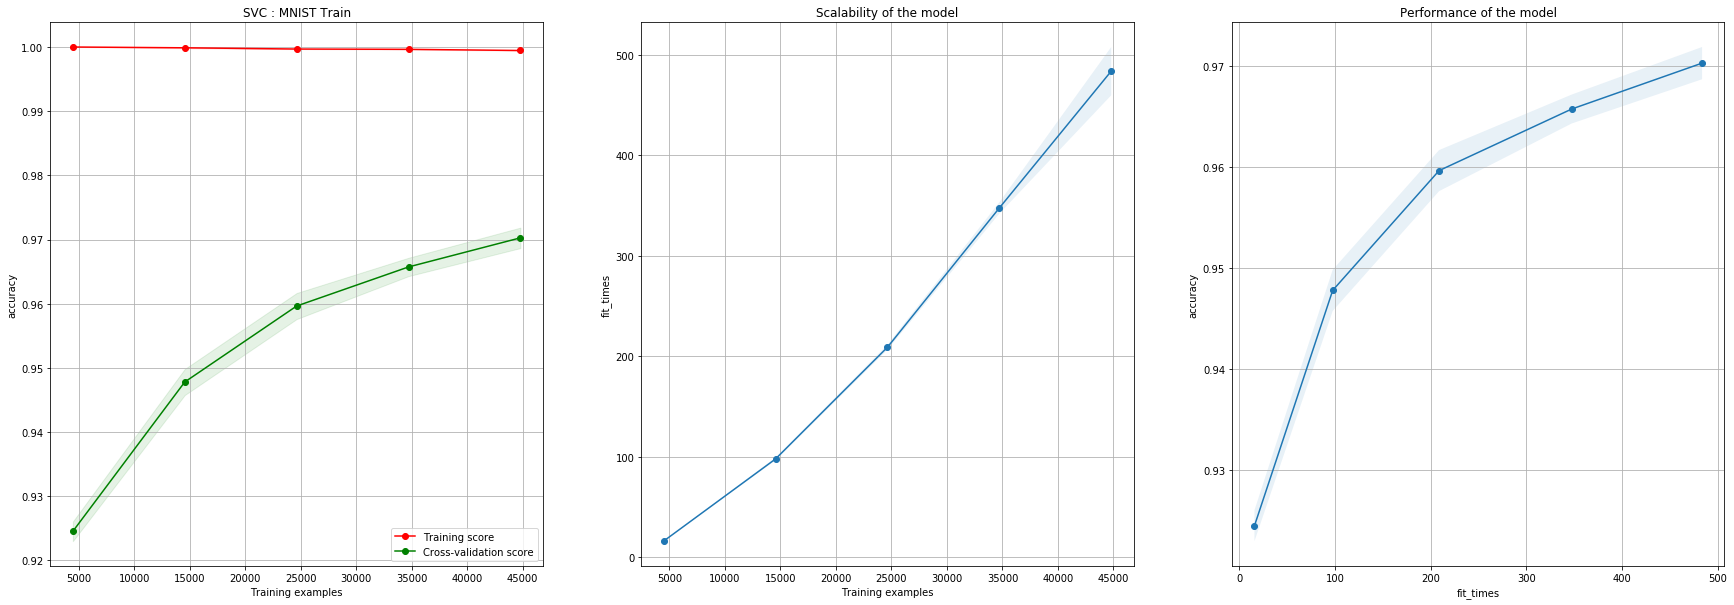

In [38]:
C = 500
gamma = 0.001
kernel = "rbf"
cache_size = 60000
msvm = SVC(C=C,
           gamma=gamma,
           kernel=kernel,
           cache_size=cache_size,
           random_state=random_state)
build_learning_curve(msvm, mnist)

SVC(C=1000, break_ties=False, cache_size=60000, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
    max_iter=-1, probability=False, random_state=2020, shrinking=True,
    tol=0.001, verbose=False)


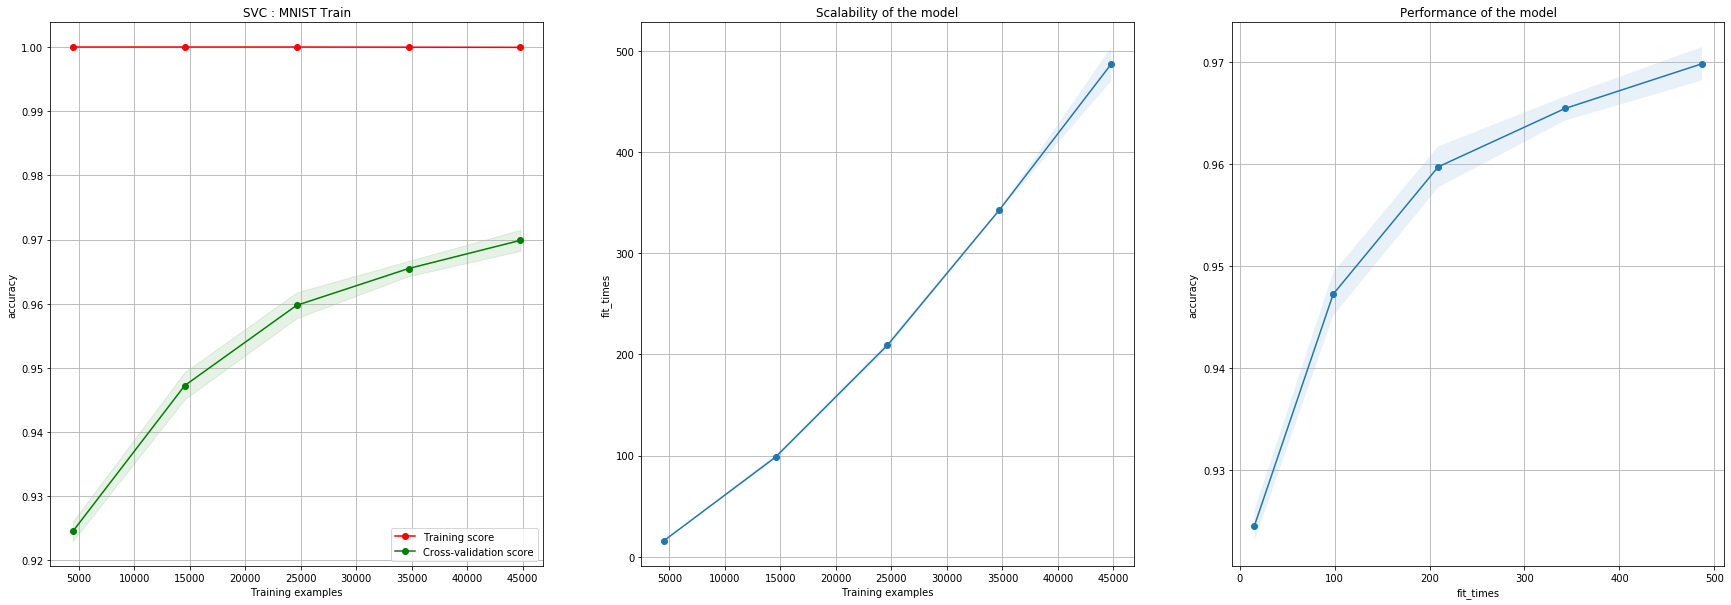

In [39]:
C = 1000
gamma = 0.001
kernel = "rbf"
cache_size = 60000
msvm = SVC(C=C,
           gamma=gamma,
           kernel=kernel,
           cache_size=cache_size,
           random_state=random_state)
build_learning_curve(msvm, mnist)

## Second Kernel

SVC(C=5, break_ties=False, cache_size=60000, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
    max_iter=-1, probability=False, random_state=2020, shrinking=True,
    tol=0.001, verbose=False)


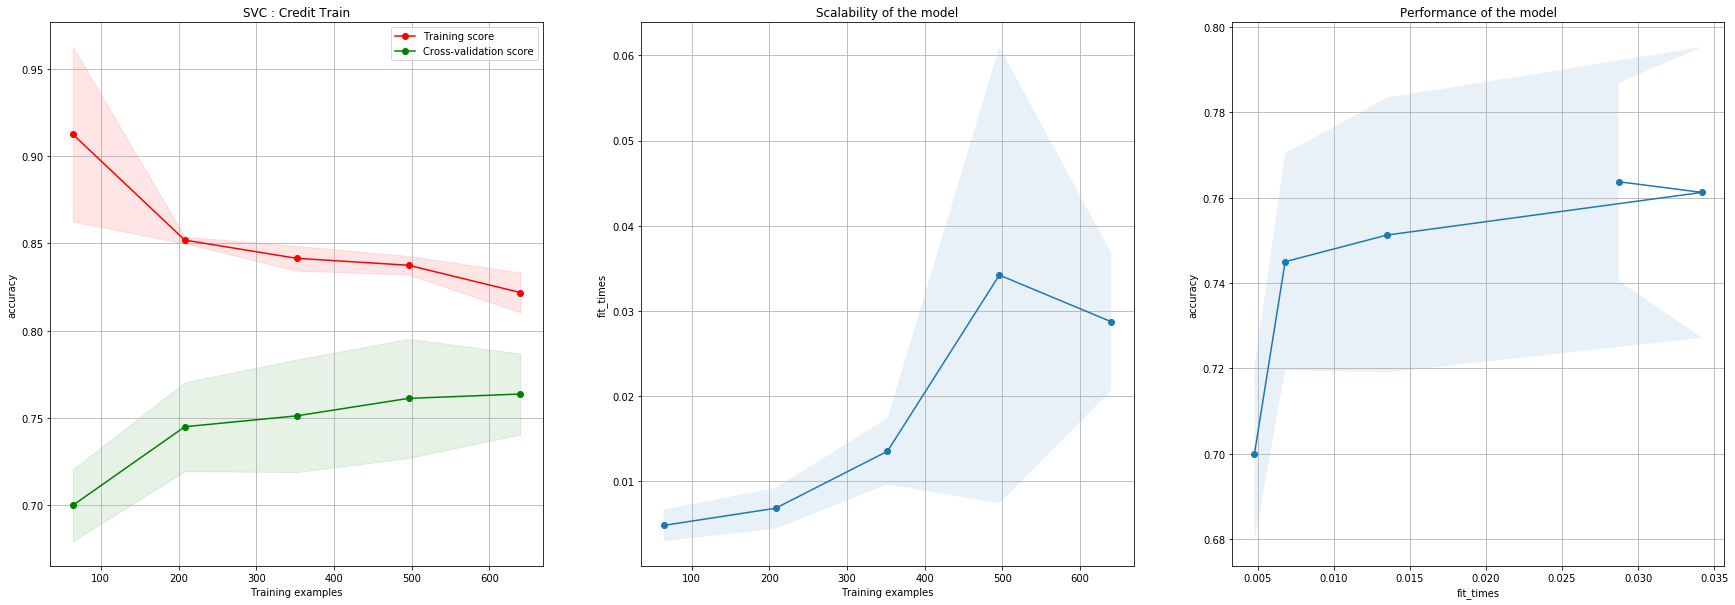

In [66]:
## rbf kernel
C = 5
gamma = 0.01
kernel = "rbf"
cache_size=60000
csvm = SVC(C=C,
           gamma=gamma,
           kernel=kernel,
           cache_size=cache_size,
           random_state=random_state)
build_learning_curve(csvm, cred)

SVC(C=5, break_ties=False, cache_size=60000, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
    max_iter=-1, probability=False, random_state=2020, shrinking=True,
    tol=0.001, verbose=False)


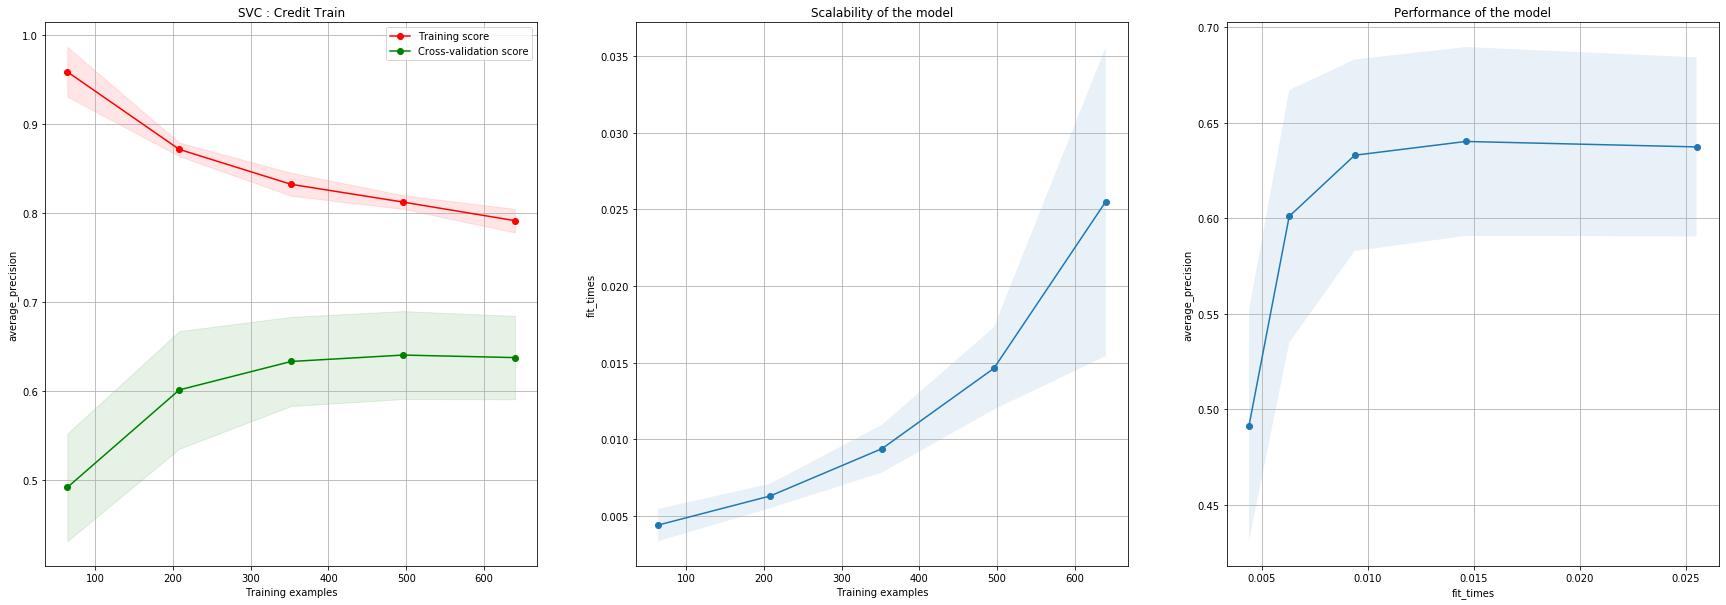

In [67]:
## rbf kernel
C = 5
gamma = 0.01
kernel = "rbf"
cache_size=60000
csvm = SVC(C=C,
           gamma=gamma,
           kernel=kernel,
           cache_size=cache_size,
           random_state=random_state)
build_learning_curve(csvm, cred, scoring="average_precision")

SVC(C=19, break_ties=False, cache_size=60000, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.001, kernel='linear',
    max_iter=-1, probability=False, random_state=2020, shrinking=True,
    tol=0.001, verbose=False)


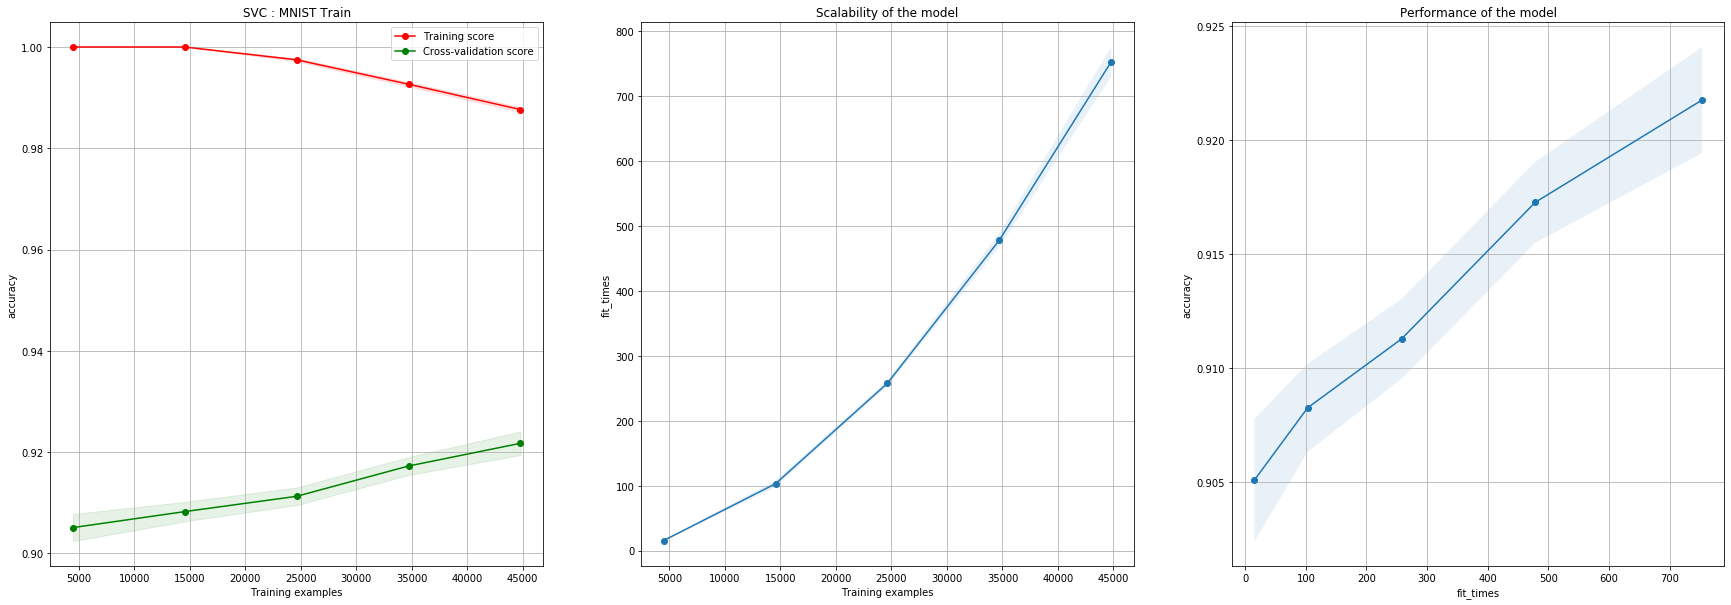

In [65]:
## Linear kernel
C = 19
gamma = 0.001
kernel = "linear"
cache_size = 60000
msvm = SVC(C=C,
           gamma=gamma,
           kernel=kernel,
           cache_size=cache_size,
           random_state=random_state)
build_learning_curve(msvm, mnist)

SVC(C=20, break_ties=False, cache_size=60000, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.001, kernel='linear',
    max_iter=-1, probability=False, random_state=2020, shrinking=True,
    tol=0.001, verbose=False)


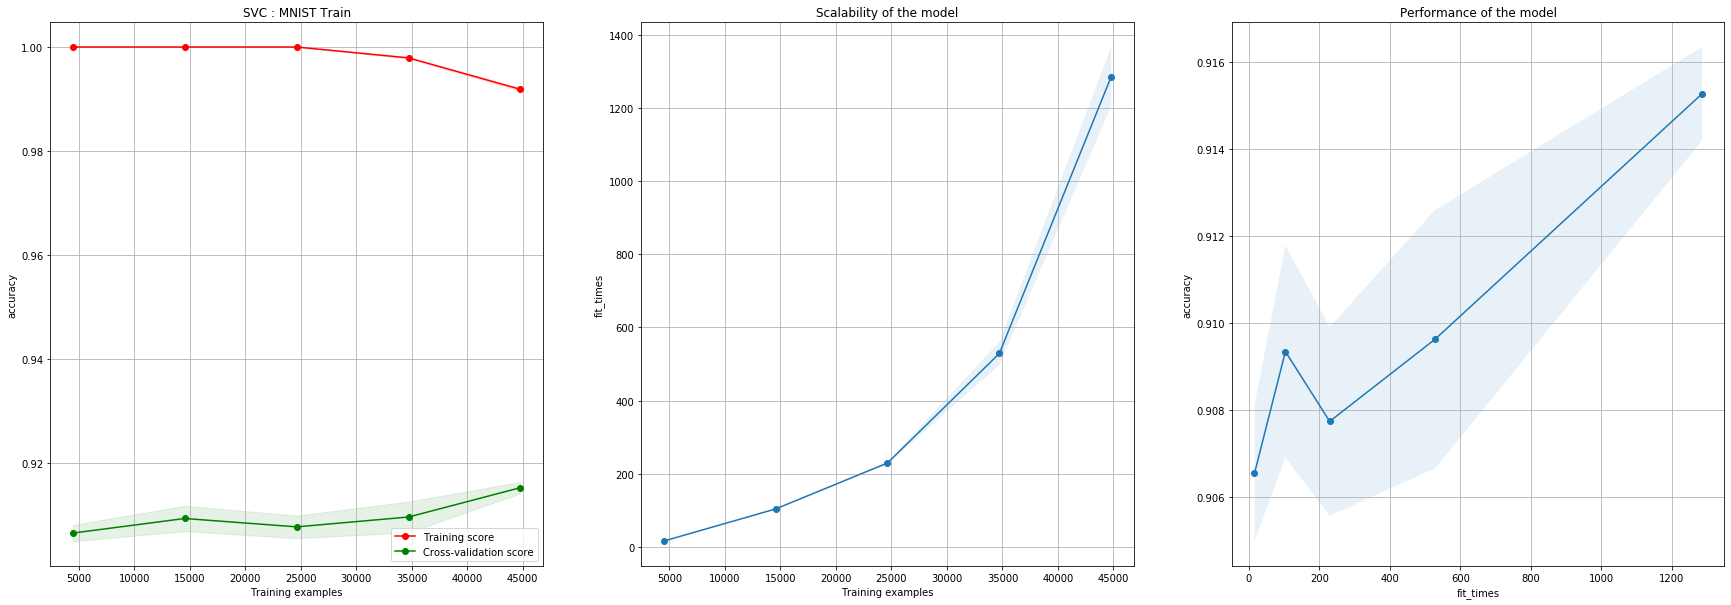

In [143]:
## Linear kernel
C = 50
gamma = 0.001
kernel = "linear"
cache_size = 60000
msvm = SVC(C=C,
           gamma=gamma,
           kernel=kernel,
           cache_size=cache_size,
           random_state=random_state)
build_learning_curve(msvm, mnist)

## Model Complexity Analysis

SVC(C=800, break_ties=False, cache_size=56000, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
    max_iter=-1, probability=False, random_state=2020, shrinking=True,
    tol=0.001, verbose=False)


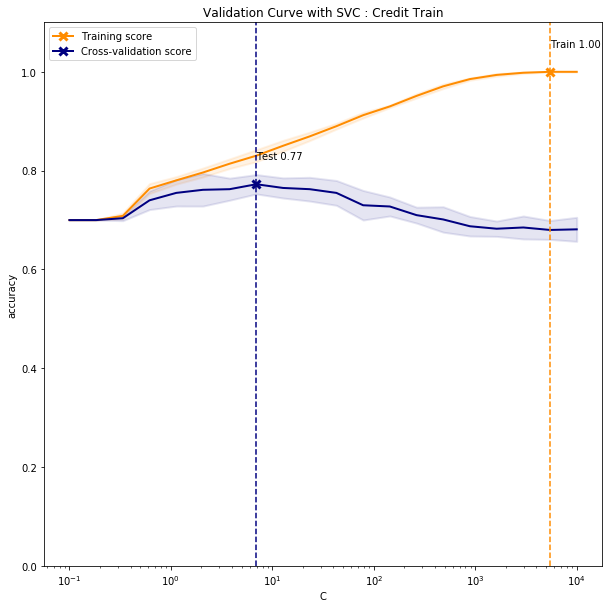

In [86]:
C = 10
gamma = 0.01
kernel = "linear"
cache_size=60000
csvm = SVC(C=C,
           gamma=gamma,
           kernel=kernel,
           cache_size=cache_size,
           random_state=random_state)
build_logx_validation_curve(csvm, cred, param_name="C", param_range=np.logspace(-1, 4, 20))

SVC(C=10, break_ties=False, cache_size=60000, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.01, kernel='linear',
    max_iter=-1, probability=False, random_state=2020, shrinking=True,
    tol=0.001, verbose=False)


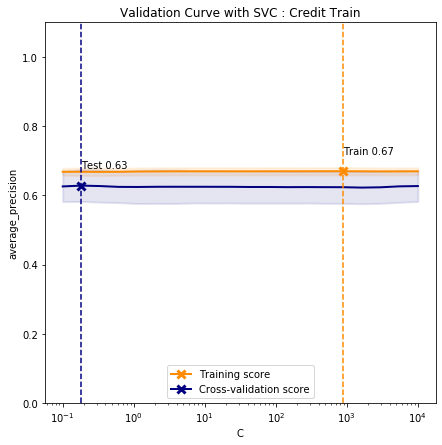

In [84]:
C = 10
gamma = 0.01
kernel = "linear"
cache_size=60000
csvm = SVC(C=C,
           gamma=gamma,
           kernel=kernel,
           cache_size=cache_size,
           random_state=random_state)
build_logx_validation_curve(csvm, cred, param_name="C", param_range=np.logspace(-1, 4, 20), scoring="average_precision")

SVC(C=10, break_ties=False, cache_size=60000, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.01, kernel='linear',
    max_iter=-1, probability=False, random_state=2020, shrinking=True,
    tol=0.001, verbose=False)


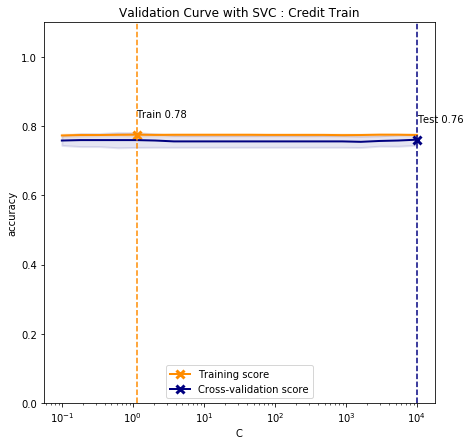

In [71]:
C = 10
gamma = 0.01
kernel = "linear"
cache_size=60000
csvm = SVC(C=C,
           gamma=gamma,
           kernel=kernel,
           cache_size=cache_size,
           random_state=random_state)
build_logx_validation_curve(csvm, cred, param_name="C", param_range=np.logspace(-1, 4, 20))

SVC(C=10, break_ties=False, cache_size=60000, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.01, kernel='linear',
    max_iter=-1, probability=False, random_state=2020, shrinking=True,
    tol=0.001, verbose=False)


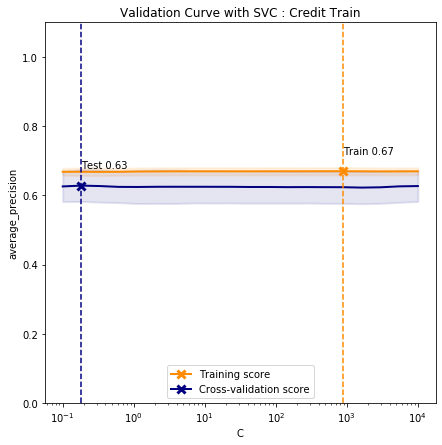

In [68]:
C = 10
gamma = 0.01
kernel = "linear"
cache_size=60000
csvm = SVC(C=C,
           gamma=gamma,
           kernel=kernel,
           cache_size=cache_size,
           random_state=random_state)
build_logx_validation_curve(csvm, cred, param_name="C", param_range=np.logspace(-1, 4, 20), scoring="average_precision")

SVC(C=800, break_ties=False, cache_size=56000, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
    max_iter=-1, probability=False, random_state=2020, shrinking=True,
    tol=0.001, verbose=False)


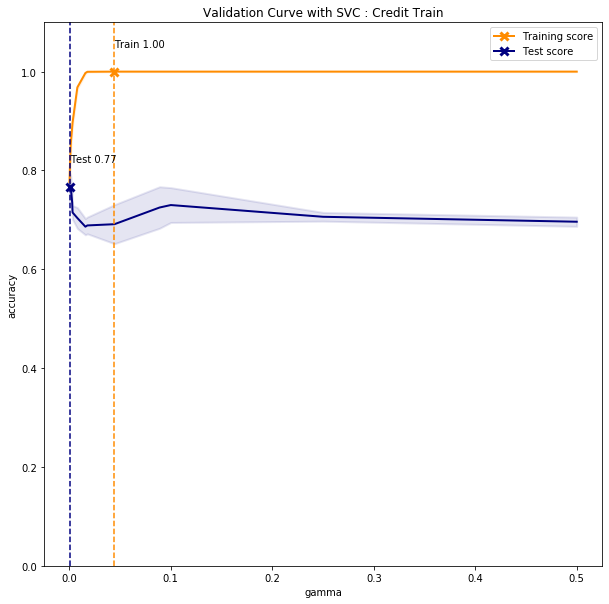

In [87]:
C = 10
gamma = 0.01
kernel = "linear"
cache_size=60000
csvm = SVC(C=C,
           gamma=gamma,
           kernel=kernel,
           cache_size=cache_size,
           random_state=random_state)
gammas = np.outer(np.logspace(-4,-1,5), np.array([1, 2.5, 5])).flatten()
build_validation_curve(csvm, cred, param_name="gamma", param_range=gammas)

SVC(C=10, break_ties=False, cache_size=60000, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.01, kernel='linear',
    max_iter=-1, probability=False, random_state=2020, shrinking=True,
    tol=0.001, verbose=False)


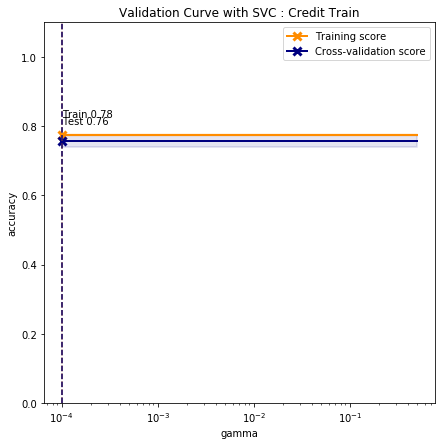

In [69]:
C = 10
gamma = 0.01
kernel = "linear"
cache_size=60000
csvm = SVC(C=C,
           gamma=gamma,
           kernel=kernel,
           cache_size=cache_size,
           random_state=random_state)
gammas = np.outer(np.logspace(-4,-1,5), np.array([1, 2.5, 5])).flatten()
build_logx_validation_curve(csvm, cred, param_name="gamma", param_range=gammas)

SVC(C=5, break_ties=False, cache_size=60000, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
    max_iter=-1, probability=False, random_state=2020, shrinking=True,
    tol=0.001, verbose=False)


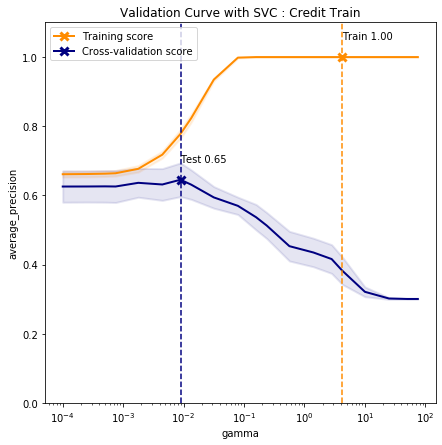

In [77]:
C = 5
gamma = 0.01
kernel = "rbf"
cache_size=60000
csvm = SVC(C=C,
           gamma=gamma,
           kernel=kernel,
           cache_size=cache_size,
           random_state=random_state)
gammas = np.outer(np.logspace(-4,1,5), np.array([1, 2.5, 5, 7.5])).flatten()
build_logx_validation_curve(csvm, cred, param_name="gamma", param_range=gammas, scoring="average_precision")

SVC(C=50, break_ties=False, cache_size=60000, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.001, kernel='linear',
    max_iter=-1, probability=False, random_state=2020, shrinking=True,
    tol=0.001, verbose=False)


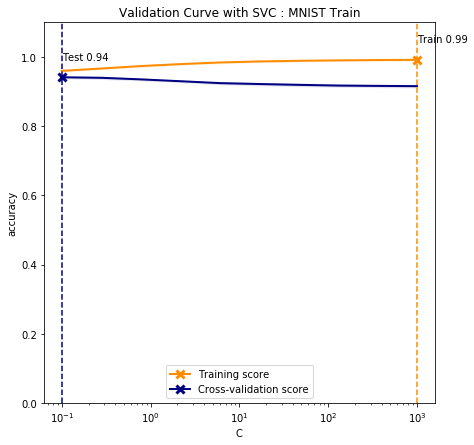

In [49]:
C = 50
gamma = 0.001
kernel = "linear"
cache_size = 60000
msvm = SVC(C=C,
           gamma=gamma,
           kernel=kernel,
           cache_size=cache_size,
           random_state=random_state)
build_logx_validation_curve(msvm, mnist, param_name="C", param_range=np.logspace(-1, 3, 10))

SVC(C=50, break_ties=False, cache_size=60000, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
    max_iter=-1, probability=False, random_state=2020, shrinking=True,
    tol=0.001, verbose=False)


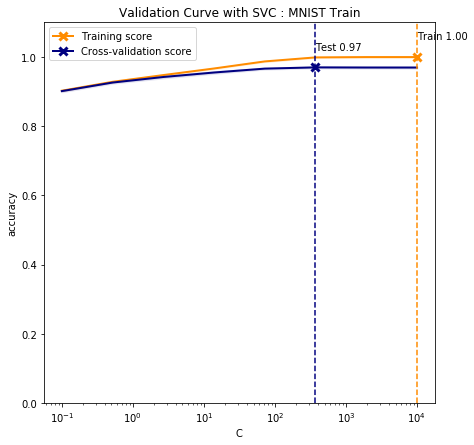

In [106]:
C = 50
gamma = 0.001
kernel = "rbf"
cache_size = 60000
msvm = SVC(C=C,
           gamma=gamma,
           kernel=kernel,
           cache_size=cache_size,
           random_state=random_state)
build_logx_validation_curve(msvm, mnist, param_name="C", param_range=np.logspace(-1, 4, 8))

SVC(C=20, break_ties=False, cache_size=60000, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
    max_iter=-1, probability=False, random_state=2020, shrinking=True,
    tol=0.001, verbose=False)


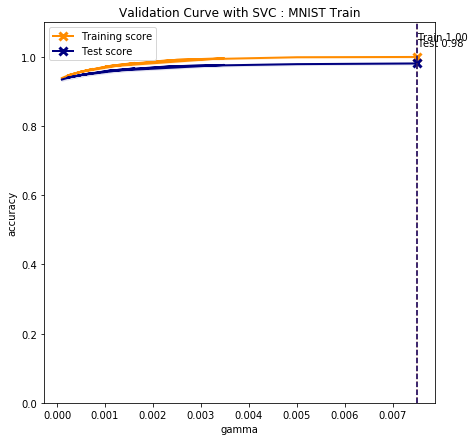

In [83]:
C = 20
gamma = 0.001
kernel = "rbf"
cache_size = 60000
msvm = SVC(C=C,
           gamma=gamma,
           kernel=kernel,
           cache_size=cache_size,
           random_state=random_state)
gammas=np.outer(np.logspace(-4,-3,4), np.array([1, 2.5, 5, 7.5])).flatten()
build_validation_curve(msvm, mnist, param_name="gamma", param_range=gammas)

SVC(C=20, break_ties=False, cache_size=60000, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
    max_iter=-1, probability=False, random_state=2020, shrinking=True,
    tol=0.001, verbose=False)


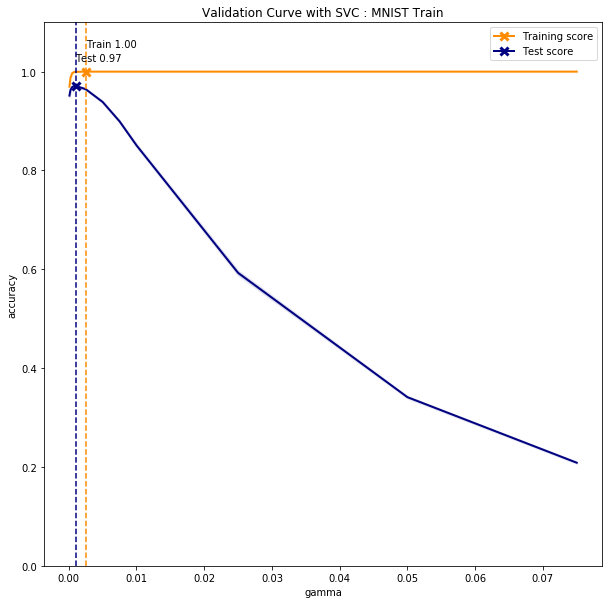

In [145]:
C = 20
gamma = 0.001
kernel = "rbf"
cache_size = 60000
msvm = SVC(C=C,
           gamma=gamma,
           kernel=kernel,
           cache_size=cache_size,
           random_state=random_state)
gammas=np.linspace(0.001, 0.01, 10)
build_validation_curve(msvm, mnist, param_name="gamma", param_range=gammas)

SVC(C=20, break_ties=False, cache_size=60000, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
    max_iter=-1, probability=False, random_state=2020, shrinking=True,
    tol=0.001, verbose=False)


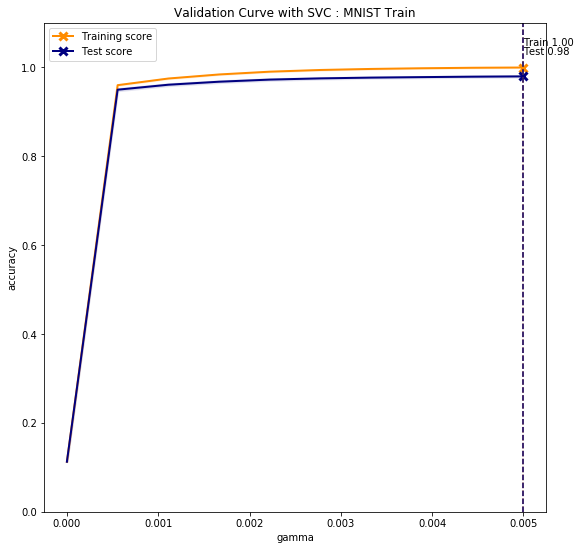

In [42]:
C = 20
gamma = 0.001
kernel = "rbf"
cache_size = 60000
msvm = SVC(C=C,
           gamma=gamma,
           kernel=kernel,
           cache_size=cache_size,
           random_state=random_state)
gammas = np.linspace(0.0,0.005, 10)
build_validation_curve(msvm, mnist, param_name="gamma", param_range=gammas)

SVC(C=20, break_ties=False, cache_size=60000, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
    max_iter=-1, probability=False, random_state=2020, shrinking=True,
    tol=0.001, verbose=False)


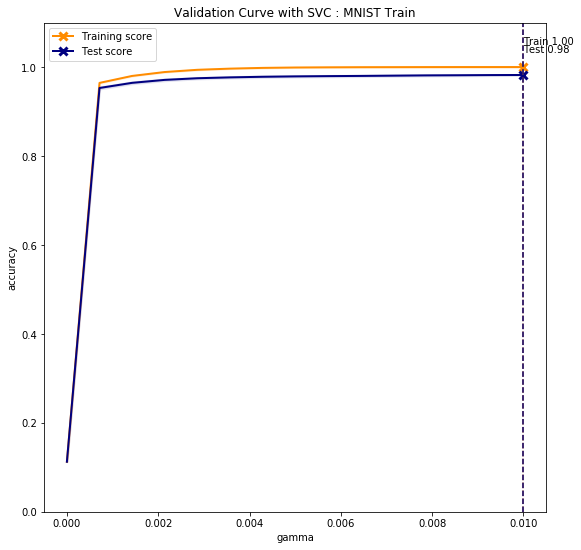

In [46]:
C = 19
gamma = 0.001
kernel = "rbf"
cache_size = 60000
msvm = SVC(C=C,
           gamma=gamma,
           kernel=kernel,
           cache_size=cache_size,
           random_state=random_state)
gammas = np.linspace(0.0001, 0.002, 10)
build_validation_curve(msvm, mnist, param_name="gamma", param_range=gammas)

### Grid Search

In [17]:
parameters = {}
tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4], 'C': [1, 10, 100, 1000]},
              {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]
              
print_gridsearch(cred, parameters= parameters, tuned_parameters=tuned_parameters, scores = ["accuracy", "roc_auc"])

# Tuning hyper-parameters for accuracy



/home/nikola/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Best parameters set found on development set:

{'C': 10, 'kernel': 'linear'}

Grid scores on development set:

0.640 (+/-0.048) for {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
0.648 (+/-0.089) for {'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}
0.620 (+/-0.064) for {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
0.620 (+/-0.108) for {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}
0.625 (+/-0.057) for {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
0.613 (+/-0.125) for {'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}
0.625 (+/-0.057) for {'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}
0.605 (+/-0.099) for {'C': 1000, 'gamma': 0.0001, 'kernel': 'rbf'}
0.710 (+/-0.024) for {'C': 1, 'kernel': 'linear'}
0.728 (+/-0.051) for {'C': 10, 'kernel': 'linear'}
0.698 (+/-0.099) for {'C': 100, 'kernel': 'linear'}
0.718 (+/-0.058) for {'C': 1000, 'kernel': 'linear'}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

              precision   

/home/nikola/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Best parameters set found on development set:

{'C': 10, 'kernel': 'linear'}

Grid scores on development set:

0.565 (+/-0.053) for {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
0.562 (+/-0.094) for {'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}
0.581 (+/-0.072) for {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
0.574 (+/-0.112) for {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}
0.586 (+/-0.088) for {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
0.586 (+/-0.076) for {'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}
0.586 (+/-0.088) for {'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}
0.584 (+/-0.047) for {'C': 1000, 'gamma': 0.0001, 'kernel': 'rbf'}
0.696 (+/-0.071) for {'C': 1, 'kernel': 'linear'}
0.703 (+/-0.109) for {'C': 10, 'kernel': 'linear'}
0.668 (+/-0.105) for {'C': 100, 'kernel': 'linear'}
0.693 (+/-0.124) for {'C': 1000, 'kernel': 'linear'}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

              precision   

In [18]:
parameters = {}
tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4], 'C': [1, 10, 100, 1000]},
              {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]
print_gridsearch(mnist, parameters=parameters, tuned_parameters=tuned_parameters, scores = ["accuracy"])

# Tuning hyper-parameters for accuracy



/home/nikola/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Best parameters set found on development set:

{'C': 1, 'kernel': 'linear'}

Grid scores on development set:

0.112 (+/-0.000) for {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
0.112 (+/-0.000) for {'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}
0.112 (+/-0.000) for {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
0.112 (+/-0.000) for {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}
0.112 (+/-0.000) for {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
0.112 (+/-0.000) for {'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}
0.112 (+/-0.000) for {'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}
0.112 (+/-0.000) for {'C': 1000, 'gamma': 0.0001, 'kernel': 'rbf'}
0.906 (+/-0.009) for {'C': 1, 'kernel': 'linear'}
0.906 (+/-0.009) for {'C': 10, 'kernel': 'linear'}
0.906 (+/-0.009) for {'C': 100, 'kernel': 'linear'}
0.906 (+/-0.009) for {'C': 1000, 'kernel': 'linear'}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

              precision    

## Fit

In [78]:
# Credit SVM
C = 5
gamma = 0.01
kernel = "rbf"
cache_size=60000
csvm = SVC(C=C,
           gamma=gamma,
           kernel=kernel,
           cache_size=cache_size,
           random_state=random_state)
csvm

SVC(C=5, break_ties=False, cache_size=60000, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
    max_iter=-1, probability=False, random_state=2020, shrinking=True,
    tol=0.001, verbose=False)

In [109]:
# MNIST SVM
C = 19
gamma = 0.001
kernel = "rbf"
cache_size=60000
msvm = SVC(C=C,
           gamma=gamma,
           kernel=kernel,
           cache_size=cache_size,
           random_state=random_state)
msvm

SVC(C=19, break_ties=False, cache_size=60000, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
    max_iter=-1, probability=False, random_state=2020, shrinking=True,
    tol=0.001, verbose=False)

In [52]:
# Fit Credit
X_c, y_c, _ = get_data(cred)
csvm = csvm.fit(X_c, y_c)

/home/nikola/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [110]:
# Fit MNIST
X_m, y_m, _ = get_data(mnist)
msvm = msvm.fit(X_m, y_m)

/home/nikola/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


## Final Performance Analysis on TRAINING Set

SVC(C=20, break_ties=False, cache_size=60000, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.01, kernel='linear',
    max_iter=-1, probability=False, random_state=2020, shrinking=True,
    tol=0.001, verbose=False)


/home/nikola/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVC(C=20, break_ties=False, cache_size=60000, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.01, kernel='linear',
    max_iter=-1, probability=False, random_state=2020, shrinking=True,
    tol=0.001, verbose=False)
Classification report for classifier SVC(C=20, break_ties=False, cache_size=60000, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.01, kernel='linear',
    max_iter=-1, probability=False, random_state=2020, shrinking=True,
    tol=0.001, verbose=False):

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       700
           1       0.30      1.00      0.46       300

    accuracy                           0.30      1000
   macro avg       0.15      0.50      0.23      1000
weighted avg       0.09      0.30      0.14      1000


SVC(C=20, break_ties=False, cache_size=60000, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.01

/home/nikola/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.6s finished


SVC : Credit Train
Scores:  [0.75625 0.76875 0.75625 0.775   0.725  ] Avg:  0.75625


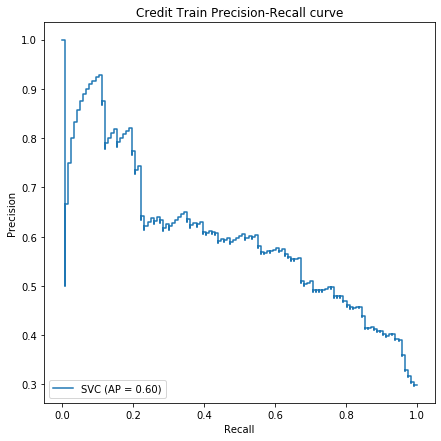

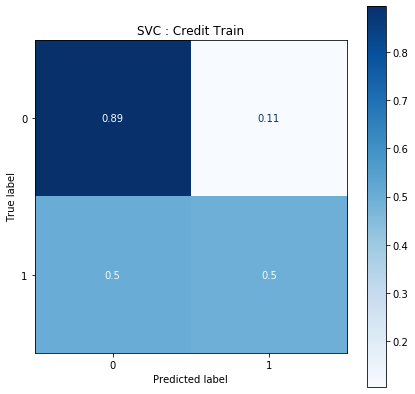

In [53]:
build_cred_precision_recall_curve(csvm, cred)
build_confusion_matrix(csvm, cred)
predicted_cred = csvm.predict(X_cred)
print("Classification report for classifier %s:\n\n%s\n" % (csvm, classification_report(y_cred, predicted_cred)))
print_cross_val(csvm, cred)

SVC(C=19, break_ties=False, cache_size=60000, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
    max_iter=-1, probability=False, random_state=2020, shrinking=True,
    tol=0.001, verbose=False)
Classification report for classifier SVC(C=19, break_ties=False, cache_size=60000, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
    max_iter=-1, probability=False, random_state=2020, shrinking=True,
    tol=0.001, verbose=False):

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      6903
           1       0.00      0.00      0.00      7877
           2       0.00      0.00      0.00      6990
           3       0.00      0.00      0.00      7141
           4       0.00      0.00      0.00      6824
           5       0.09      1.00      0.17      6313
           6       0.00      0.00      0.00      6876
           7       0.00      0

/home/nikola/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 16.3min finished


SVC : MNIST Train
Scores:  [0.95446429 0.96       0.95883929 0.96080357 0.95642857] Avg:  0.9581071428571428


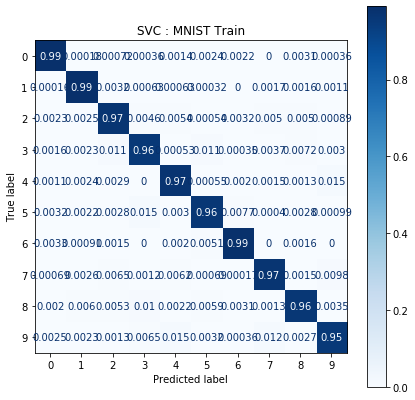

In [58]:
build_confusion_matrix(msvm, mnist)
predicted_mnist = msvm.predict(X_mnist)
print("Classification report for classifier %s:\n\n%s\n" % (msvm, classification_report(y_mnist, predicted_mnist)))
print_cross_val(msvm, mnist)

SVC(C=19, break_ties=False, cache_size=60000, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
    max_iter=-1, probability=False, random_state=2020, shrinking=True,
    tol=0.001, verbose=False)
Classification report for classifier SVC(C=19, break_ties=False, cache_size=60000, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
    max_iter=-1, probability=False, random_state=2020, shrinking=True,
    tol=0.001, verbose=False):

              precision    recall  f1-score   support

           0      0.000     0.000     0.000      6903
           1      0.000     0.000     0.000      7877
           2      0.000     0.000     0.000      6990
           3      0.000     0.000     0.000      7141
           4      0.000     0.000     0.000      6824
           5      0.090     1.000     0.165      6313
           6      0.000     0.000     0.000      6876
           7      0.000     0.00

/home/nikola/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  5.0min finished


SVC : MNIST Train
Scores:  [0.981875   0.98375    0.98294643 0.981875   0.980625  ] Avg:  0.9822142857142857


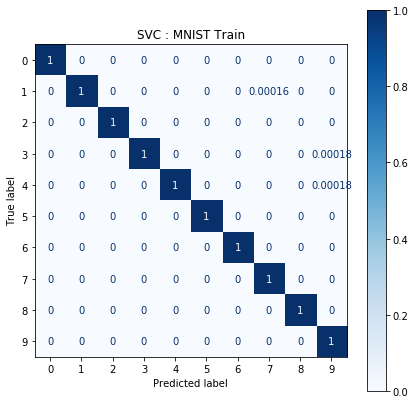

In [62]:
build_confusion_matrix(msvm, mnist)
predicted_mnist = msvm.predict(X_mnist)
print("Classification report for classifier %s:\n\n%s\n" % (msvm, classification_report(y_mnist, predicted_mnist, digits=3)))
print_cross_val(msvm, mnist)

## Final Performance Analysis on TEST Set

SVC(C=10, break_ties=False, cache_size=60000, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.01, kernel='linear',
    max_iter=-1, probability=False, random_state=2020, shrinking=True,
    tol=0.001, verbose=False)
SVC(C=10, break_ties=False, cache_size=60000, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.01, kernel='linear',
    max_iter=-1, probability=False, random_state=2020, shrinking=True,
    tol=0.001, verbose=False)
Classification report for classifier SVC(C=10, break_ties=False, cache_size=60000, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.01, kernel='linear',
    max_iter=-1, probability=False, random_state=2020, shrinking=True,
    tol=0.001, verbose=False):

              precision    recall  f1-score   support

           0       0.85      0.88      0.86       140
           1       0.69      0.63      0.66        60

    accuracy                           0.81 

/home/nikola/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


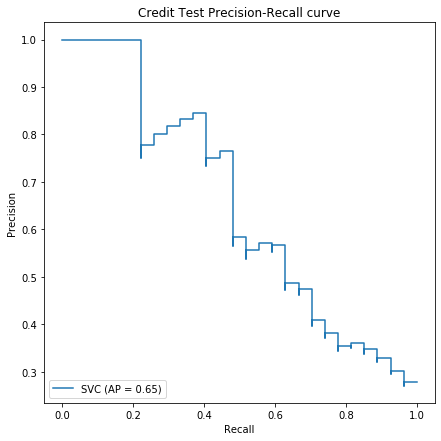

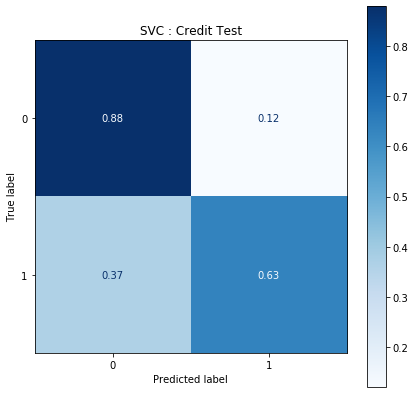

In [103]:
build_cred_precision_recall_curve(csvm, cred_test)
build_confusion_matrix(csvm, cred_test)
predicted_cred = csvm.predict(X_cred_test)
print("Classification report for classifier %s:\n\n%s\n" % (csvm, classification_report(y_cred_test, predicted_cred)))

SVC(C=50, break_ties=False, cache_size=60000, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
    max_iter=-1, probability=False, random_state=2020, shrinking=True,
    tol=0.001, verbose=False)
Classification report for classifier SVC(C=50, break_ties=False, cache_size=60000, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
    max_iter=-1, probability=False, random_state=2020, shrinking=True,
    tol=0.001, verbose=False):

              precision    recall  f1-score   support

           0       0.98      0.99      0.99      1381
           1       0.98      0.98      0.98      1575
           2       0.96      0.97      0.97      1398
           3       0.97      0.97      0.97      1428
           4       0.97      0.97      0.97      1365
           5       0.97      0.96      0.97      1263
           6       0.98      0.97      0.98      1375
           7       0.94      0

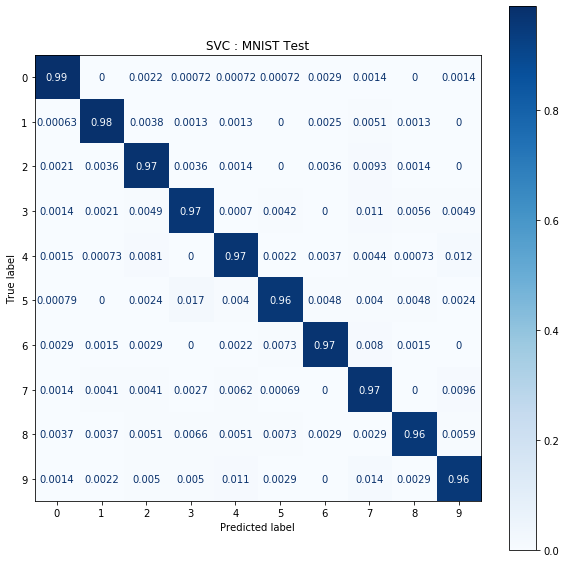

In [161]:
build_confusion_matrix(msvm, mnist_test)
predicted_mnist = msvm.predict(X_mnist_test)
print("Classification report for classifier %s:\n\n%s\n" % (msvm, classification_report(y_mnist_test, predicted_mnist)))

SVC(C=19, break_ties=False, cache_size=60000, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
    max_iter=-1, probability=False, random_state=2020, shrinking=True,
    tol=0.001, verbose=False)
Classification report for classifier SVC(C=19, break_ties=False, cache_size=60000, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
    max_iter=-1, probability=False, random_state=2020, shrinking=True,
    tol=0.001, verbose=False):

              precision    recall  f1-score   support

           0      0.974     0.991     0.982      1381
           1      0.976     0.988     0.982      1575
           2      0.944     0.959     0.951      1398
           3      0.949     0.950     0.950      1428
           4      0.950     0.960     0.955      1365
           5      0.946     0.933     0.940      1263
           6      0.971     0.974     0.972      1375
           7      0.966     0.

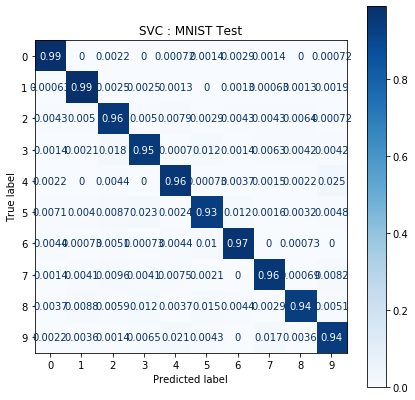

In [111]:
build_confusion_matrix(msvm, mnist_test)
predicted_mnist = msvm.predict(X_mnist_test)
print("Classification report for classifier %s:\n\n%s\n" % (msvm, classification_report(y_mnist_test, predicted_mnist, digits=3)))